# **<u>SPRINT 2<u>**

In [131]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
import missingno as msno
import scipy
from scipy.stats import chi2_contingency, shapiro, normaltest, anderson, pearsonr
import json
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from yellowbrick.regressor import ResidualsPlot, PredictionError
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
import math
from matplotlib.ticker import PercentFormatter
from xgboost import XGBRegressor

In [2]:
warnings.filterwarnings(action="ignore")

<!--  -->

### DEF FUNCTIONS

Cargamos las funciones que van a ser utilizadas en el Proyecto

1) PRUEBA DE NORMALIDAD

In [3]:
def normal_test(data: pd.DataFrame, column: str, alpha: float = 0.05, method: str = "shapiro"):
    """
    Calcula la prueba de normalidad sobre una variable de interes.
    :param data: DataFrame
    :param column: variable para probar normalidad
    :param alpha: nivel de significancia
    :param method: tipo de prueba de normalidad
    :return: NoneType
    """
    if method in ["shapiro", "d'agostino", "anderson"]:
        if method == "shapiro":
            stat, p = shapiro(data[column])
            print(f"Para {column} con la prueba de Shapiro-Wilks: \n")
        elif method == "d'agostino":
            stat, p = normaltest(data[column])
            print(f"Para {column} con la prueba de K^2 de D'Agostino: \n")
        else:
            result = anderson(data[column])
            print(f"Para {column} con la prueba de Anderson-Darling: \n")
            print(f"Estadistico: {round(result.statistic)}")
            alphas = [0.15, 0.1, 0.05, 0.025, 0.01]
            if alpha in alphas:
                idx = alphas.index(alpha)
                sl, cv = result.significance_level[idx], result.critical_values[idx]
                if result.statistic < result.critical_values[idx]:
                    print(f"Para un nivel de significancia: {sl} y un valor critico de: {cv} \n"
                          f"La muestra parece Gaussiana (No se rechaza H0).")
                else:
                    print(f"Para un nivel de significancia: {sl} y un valor critico de: {cv} \n"
                          f"La muestra no parece Gaussiana (Se rechaza H0).")
            else:
                ValueError("El nivel de significancia proporcionado no esta disponible para esta prueba.")
        if method in ["shapiro", "d'agostino"]:
            print(f"Estadístico: {round(stat, 3)} \n"
                  f"P-value: {round(p, 4)} \n")
            if p > alpha:
                print("La muestra parece Gaussiana (No se rechaza H0).")
            else:
                print("La muestra no parece Gaussiana (Se rechaza H0).")
    else:
        ValueError("El metodo debe ser shapiro, d'agostino o anderson")
    return None

2) CALCULO DEL VIF

In [4]:
def calculate_vif(data: pd.DataFrame):
    vif = pd.DataFrame()
    vif["feature"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
    return vif

<!--  -->

# <u>REQUERIMIENTOS MINIMOS<u>

# 1) CARGA Y ANALISIS DEL DATASET

In [5]:
# Cargamos el DS de Properati
prop = pd.read_csv('Documents/Acamica/Sprint 2/Proyecto 2/DS_Proyecto_01_Datos_Properati.csv')

In [6]:
# Imprimimos un head para una primera observacion del DS
prop.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


In [7]:
# Tamaño y forma del DS
print(f'El DS tiene {len(prop.columns)} columnas y {len(prop)} filas')

El DS tiene 19 columnas y 146660 filas


In [8]:
# Descripcion de las variables numericas
prop.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,136735.000000,136701.000000,146660.000000,146660.000000,140703.000000,126133.000000,125046.000000,1.466600e+05
mean,-34.604896,-58.465304,3.079817,1.983240,1.599994,216.872888,112.818011,2.412211e+05
std,0.468428,0.486190,1.416352,1.151304,0.889324,2037.606649,916.857584,3.185195e+05
min,-35.318457,-180.000000,1.000000,0.000000,1.000000,10.000000,1.000000,5.500000e+03
25%,-34.627667,-58.504012,2.000000,1.000000,1.000000,52.000000,47.000000,1.110000e+05
50%,-34.600943,-58.443262,3.000000,2.000000,1.000000,78.000000,68.000000,1.660000e+05
75%,-34.574600,-58.407586,4.000000,3.000000,2.000000,140.000000,108.000000,2.650000e+05
max,85.051129,-57.805832,35.000000,15.000000,14.000000,193549.000000,126062.000000,3.243423e+07


En principio, podriamos decir que las variables `rooms` y `bedrooms` tienen distribuciones normales, ya que la media y la mediana de cada variable son muy similares. Mas adelante se realizara una prueba de hipoteis para confirmar la distribucion de las variables numericas anteriores

In [9]:
# Descripcion de las variables categoricas
prop.describe(exclude = 'number')

,start_date,end_date,created_on,l1,l2,l3,currency,title,description,property_type,operation_type
count,146660,146660,146660,146660,146660,146660,146660,146660,146660,146660,146660
unique,366,412,366,1,4,89,1,77733,106668,10,1
top,2019-07-31,9999-12-31,2019-07-31,Argentina,Capital Federal,Palermo,USD,DEPARTAMENTO EN VENTA,EDIFICIO DE CATEGORIA CON MATERIALES Y ACCESOR...,Departamento,Venta
freq,11022,25101,11022,146660,92539,13073,146660,5064,235,107326,146660


In [10]:
# Informacion acerca de data types de los atributos y cantidad de datos NaN
prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146660 entries, 0 to 146659
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   start_date       146660 non-null  object 
 1   end_date         146660 non-null  object 
 2   created_on       146660 non-null  object 
 3   lat              136735 non-null  float64
 4   lon              136701 non-null  float64
 5   l1               146660 non-null  object 
 6   l2               146660 non-null  object 
 7   l3               146660 non-null  object 
 8   rooms            146660 non-null  float64
 9   bedrooms         146660 non-null  float64
 10  bathrooms        140703 non-null  float64
 11  surface_total    126133 non-null  float64
 12  surface_covered  125046 non-null  float64
 13  price            146660 non-null  float64
 14  currency         146660 non-null  object 
 15  title            146660 non-null  object 
 16  description      146660 non-null  obje

In [11]:
# Contabilizar valores unicos de las variables 'currency' y 'operation_type'
currency = len(pd.unique(prop['currency']))
operation_type = len(pd.unique(prop['operation_type']))

print('currency:', currency, '\n', 'operation_type:', operation_type)

currency: 1 
 operation_type: 1


- Como se puede observar, las variables `currency` y `operation_type` tienen un unico valor cada una, por lo que quedan **descartadas** para cualquier tipo de analisis. 
- A esto, sumarle que, las variables `title` y `description`, tambien quedan fuera de analisis ya que las mismas tienen datos cargados por los usuarios de Properati, por ende, no existe estandarizacion alguna de la informacion, y cualquier arreglo que pueda realizarse sobre dichas variables, demandara mas trabajo que el valor agregado que estas puedan sumar a cualquier modelo.

In [12]:
# Secuencia que determina si los datos de una variable son identicos a otra variable
var = ['start_date', 'created_on']

mask = (prop['start_date'] == prop['created_on']).sum()
values = len(prop.index)

if mask == values:
    print(f'Ambas variables {var[0]} y {var[1]} tienen los mismos datos')
else:
    print(f'Las variables {var[0]} y {var[1]} no tienen los mismos datos')

Ambas variables start_date y created_on tienen los mismos datos


- La variable `created_on` tiene los mismos valores que la variable `start_date`, por lo que sera descartada, ya que considerarla seria redundante.

In [13]:
# Convertimos las columnas de 'start_date' y 'end_date' en formato mes-año para la busqueda de un patron de manera mensual
prop['start_date'] = pd.to_datetime(prop['start_date'], errors = 'coerce', format = '%Y-%m-%d')
prop['end_date'] = pd.to_datetime(prop['end_date'], errors = 'coerce', format = '%Y-%m-%d')

In [14]:
# En dos nuevas columnas, coloca el mes-año correspondiente a 'start_date' y 'end_date', respectivamente
prop['start_date_month'] = pd.DatetimeIndex(prop['start_date']).month
prop['end_date_month'] = pd.DatetimeIndex(prop['end_date']).month

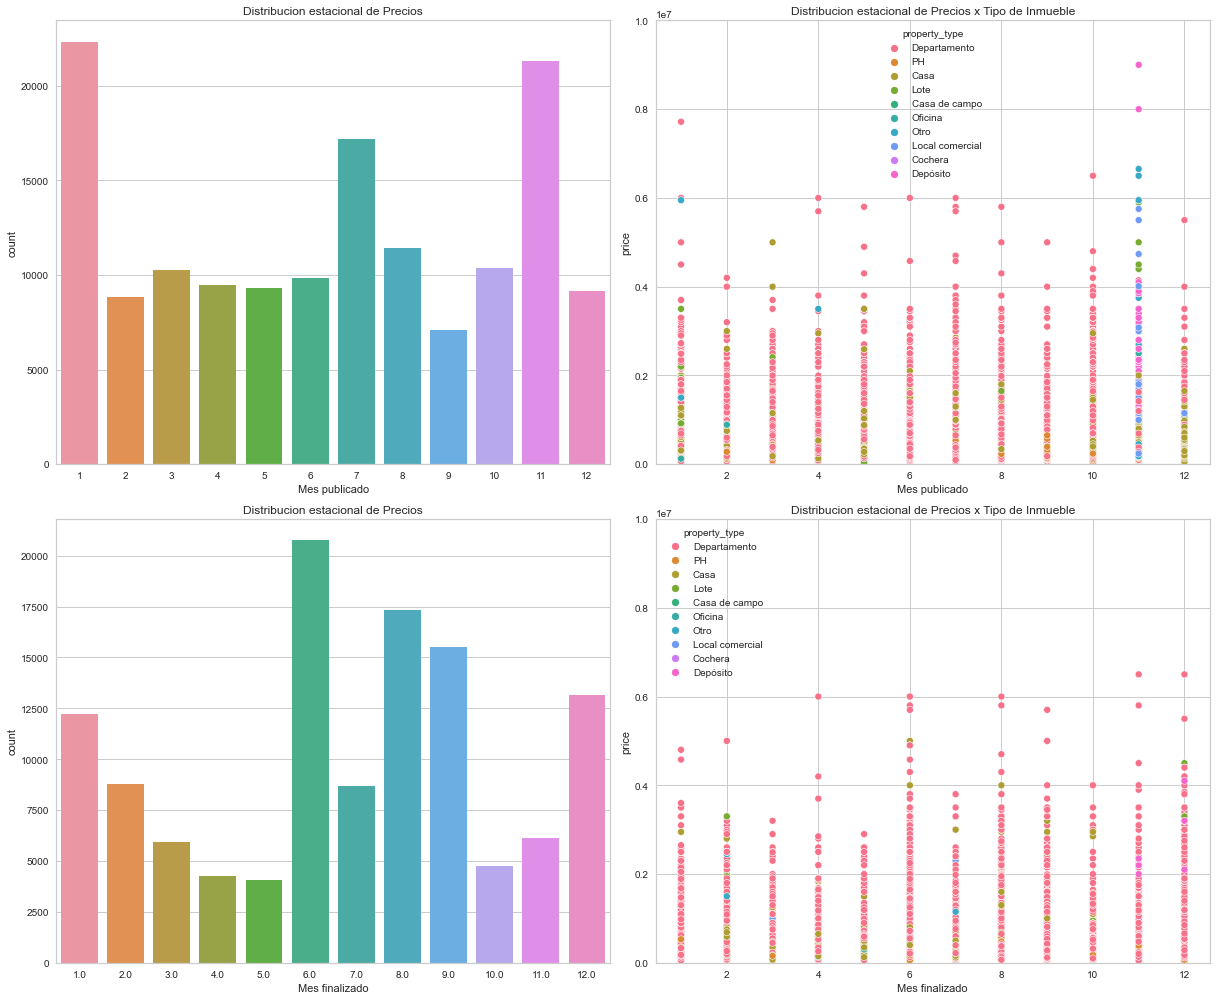

In [15]:
plt.figure(figsize = (17, 14))

plt.subplot(2, 2, 1)
start_date_count = sns.countplot(data = prop, x = 'start_date_month')
plt.title('Distribucion estacional de Precios')
plt.xlabel('Mes publicado')

plt.subplot(2, 2, 2)
sns.scatterplot(data = prop, x = 'start_date_month', y = 'price', hue = 'property_type')
plt.title('Distribucion estacional de Precios x Tipo de Inmueble')
plt.xlabel('Mes publicado')
plt.ylim(0, 1e7)

plt.subplot(2, 2, 3)
start_date_count = sns.countplot(data = prop, x = 'end_date_month')
plt.title('Distribucion estacional de Precios')
plt.xlabel('Mes finalizado')

plt.subplot(2, 2, 4)
sns.scatterplot(data = prop, x = 'end_date_month', y = 'price', hue = 'property_type')
plt.title('Distribucion estacional de Precios x Tipo de Inmueble')
plt.xlabel('Mes finalizado')
plt.ylim(0, 1e7)

plt.tight_layout()
plt.show()

- Observando los graficos inmediatos anteriores, podemos decir que no existe estacionalidad en la variacion de los precios de los inmuebles, por lo que las variables `start_date` y `end_date` no aportan informacion valiosa para el analisis del DS y estas seran descartadas para el modelo.
- Como comentario adicional, las variables `lat` y `lon` relacionadas al posicionamiento geografico, seran descartadas, ya que las mismas pueden ser reemplazadas facilmente por la variable `l3` que nos brinda informacion sobre la localidad de los inmuebles

Procederemos a eliminar las variables mencionadas anteriormente, incluyendo las variables creadas `start_date_month` y `end_date_month`

In [16]:
label = ['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'currency', 'title', 'description', 'operation_type', 'start_date_month', 'end_date_month']
prop = prop.drop(labels = label, axis = 1)
prop = pd.DataFrame(prop)
prop.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,PH


In [17]:
# Nos aseguramos que la cantidad de observaciones no fue alterada
prop.shape

(146660, 9)

Chequeamos si existen observaciones de `surface_covered` con valores mayores a `surface_total`, ya que esto seria inconsistente. En caso de que existan, seran reemplazados por el valor de `surface_total` correspondiente.

In [18]:
# Mascara de cumplimiento de condicion
mask = prop['surface_covered'] > prop['surface_total']

# Condicion para reemplazo de valores
if mask.sum() > 0:
    print(f'Se encontraron {mask.sum()} observaciones de `surface_covered` mayores a `surface_total`')
    # Reemplazo por valores de `surface_total`
    prop.loc[prop['surface_covered'] > prop['surface_total'], 'surface_covered'] = prop['surface_total']
    print('Fueron reemplzados por el valor de `surface_total` correspondiente')
else:
    print('No se encontraron obsevaciones de `surface_covered` mayores a `surface_total`')

Se encontraron 1432 observaciones de `surface_covered` mayores a `surface_total`
Fueron reemplzados por el valor de `surface_total` correspondiente


<!--  -->

### ANALISIS UNIVARIADO

#### 1) VARIABLES NUMERICAS

In [19]:
# Lista de variables numericas
numerical_col = prop.select_dtypes(include = 'number').drop('price', axis = 1).columns.tolist()
numerical_col

['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']

In [20]:
# Lista de variables categoricas
categorical_col = prop.select_dtypes(exclude = 'number').columns.tolist()
categorical_col

['l2', 'l3', 'property_type']

<!--  -->

Visualizaremos la distribucion de las variables y luego realizaremos una prueba de normalidad

La variable rooms: 



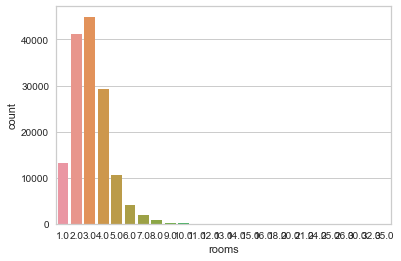

-----------------------------------------------------------------------------------------------------------
La variable bedrooms: 



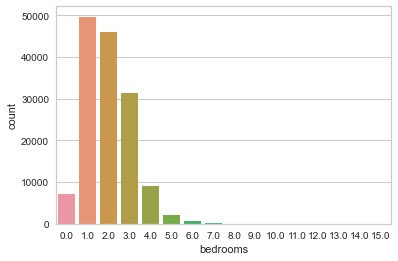

-----------------------------------------------------------------------------------------------------------
La variable bathrooms: 



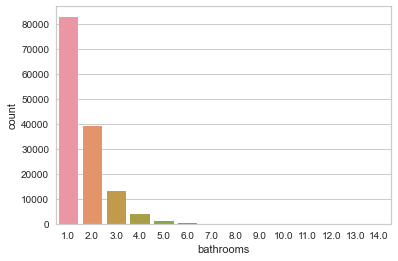

-----------------------------------------------------------------------------------------------------------
La variable surface_total: 



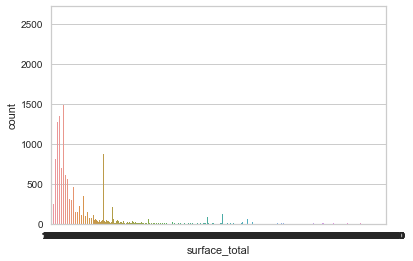

-----------------------------------------------------------------------------------------------------------
La variable surface_covered: 



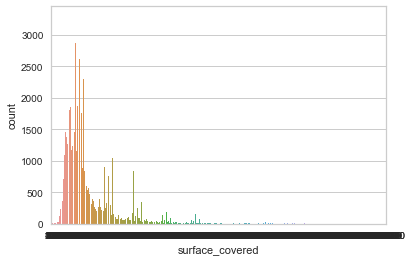

-----------------------------------------------------------------------------------------------------------


In [21]:
# Graficos tipos countplot
for col in numerical_col:
    print(f"La variable {col}: \n")
    sns.countplot(data = prop, x = col)
    plt.show()
    print("-----------------------------------------------------------------------------------------------------------")

In [22]:
for col in numerical_col:
    print(f"Para la variable {col}")
    normal_test(data = prop, column = col, method = 'shapiro')
    print("----------------------------------------------------------------------------------------------------------- \n")

Para la variable rooms
Para rooms con la prueba de Shapiro-Wilks: 

Estadístico: 0.872 
P-value: 0.0 

La muestra no parece Gaussiana (Se rechaza H0).
----------------------------------------------------------------------------------------------------------- 

Para la variable bedrooms
Para bedrooms con la prueba de Shapiro-Wilks: 

Estadístico: 0.882 
P-value: 0.0 

La muestra no parece Gaussiana (Se rechaza H0).
----------------------------------------------------------------------------------------------------------- 

Para la variable bathrooms
Para bathrooms con la prueba de Shapiro-Wilks: 

Estadístico: nan 
P-value: 1.0 

La muestra parece Gaussiana (No se rechaza H0).
----------------------------------------------------------------------------------------------------------- 

Para la variable surface_total
Para surface_total con la prueba de Shapiro-Wilks: 

Estadístico: nan 
P-value: 1.0 

La muestra parece Gaussiana (No se rechaza H0).
----------------------------------------

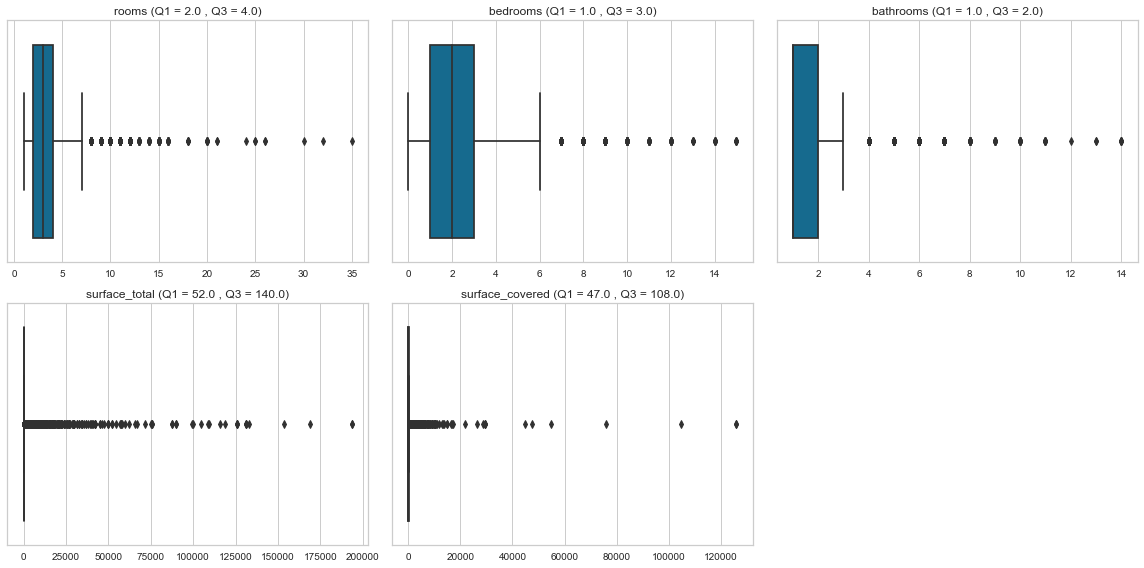

In [23]:
a = 2 # Numero de filas del subplot
b = 3 # Numero de columnas del subplot
c = 1 # Iniciador del contador

fig = plt.figure(figsize = (16, 8))

for col in numerical_col:
    plt.subplot(a, b, c)
    plt.title(f'{col} (Q1 = {prop[col].quantile(0.25)} , Q3 = {prop[col].quantile(0.75)})')
    ax = sns.boxplot(data = prop, x = col)
    ax.set(xlabel = None)
    c = c + 1
    
plt.tight_layout()
plt.show()

<!--  -->

#### 2) VARIABLES CATEGORICAS

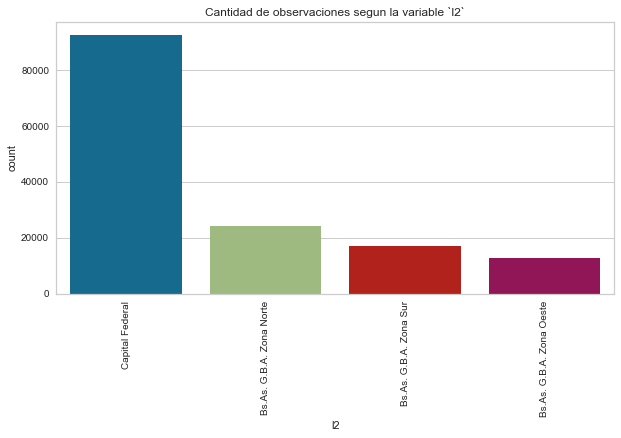

La clase con mas cantidad de observaciones es Capital Federal
------------------------------------------------------------------------------------------------------------------------- 



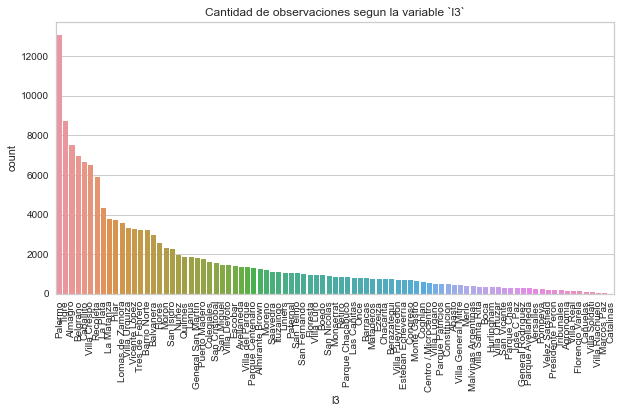

La clase con mas cantidad de observaciones es Palermo
------------------------------------------------------------------------------------------------------------------------- 



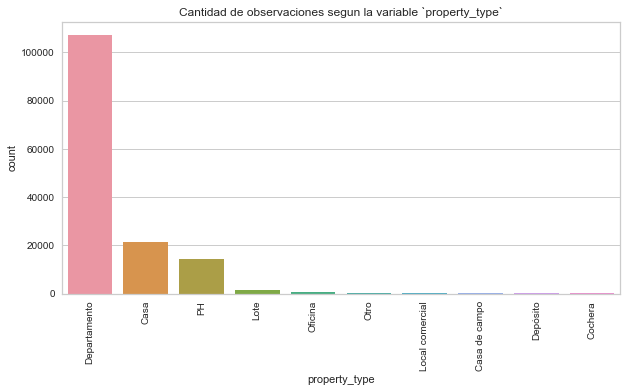

La clase con mas cantidad de observaciones es Departamento
------------------------------------------------------------------------------------------------------------------------- 



In [24]:
for col in categorical_col:
    # Tamaño del grafico
    fig, ax = plt.subplots(figsize = (10, 5))
    # Graficamos
    ax = sns.countplot(data = prop, x = col, order = prop[col].value_counts().index)
    # Etiquetas del eje "x" con orientacion vertical
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    plt.title(f'Cantidad de observaciones segun la variable `{col}`')
    plt.show()
    print(f'La clase con mas cantidad de observaciones es {prop[col].value_counts().index[0]}')
    print('------------------------------------------------------------------------------------------------------------------------- \n')

In [25]:
# Creamos una tabla para ilustrar la frecuencia por cada clase
Frecuencia = round(prop['property_type'].value_counts(normalize = True).cumsum() * 100, 1).reset_index(name = 'Freq')
# Imprimimos tabla
print(display(Frecuencia))

,index,Freq
0,Departamento,73.2
1,Casa,87.9
2,PH,97.6
3,Lote,98.5
4,Oficina,98.9
5,Otro,99.2
6,Local comercial,99.4
7,Casa de campo,99.6
8,Depósito,99.8
9,Cochera,100.0


None


Notar que las 3 primeras clases (`Departamento`, `Casa` y `PH`) representan el 97,6% de la muestra, por lo que se procedera a agrupar el resto de las clases, que representan unicamente el 2,4% de la muestra y comprenden 7 clases diferentes, en una nueva categoria llamada `Otros`.

In [26]:
# Llamamos al top 3 de los `property_type` con mayor frecuencia de observaciones
top = prop['property_type'].value_counts().nlargest(3).index
# Creamos una nueva variable con los `property_type` agrupados como se describio anteriormente
prop['property_clean'] = prop['property_type'].where(prop['property_type'].isin(top), other = 'Otros')

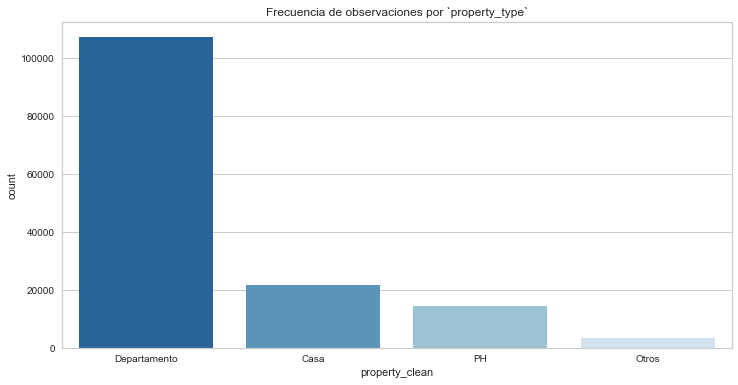

,index,Freq
0,Departamento,73.2
1,Casa,87.9
2,PH,97.6
3,Otros,100.0


In [27]:
# Hacemos un countplot
plt.figure(figsize = (12, 6))
sns.countplot(data = prop, x = 'property_clean', order = prop['property_clean'].value_counts().index, palette = 'Blues_r')
plt.title('Frecuencia de observaciones por `property_type`')
plt.show()
# Creamos una tabla para ilustrar la frecuencia por cada clase
Frecuencia = round(prop['property_clean'].value_counts(normalize = True).cumsum() * 100, 1).reset_index(name = 'Freq')
# Imprimimos tabla
Frecuencia

<!--  -->

Volvemos a definir la lista de variables categoricas que definimos anteriormente como `categorical_col`, eliminando de la misma `property_type` por `property_clean`

In [28]:
# Lista de variables categoricas
categorical_col = prop.drop('property_type', axis = 1).select_dtypes(exclude = 'number').columns.tolist()
categorical_col

['l2', 'l3', 'property_clean']

Asi mismo, eliminaremos del DS la variable `property_type`

In [29]:
prop.drop('property_type', axis = 1, inplace = True)
prop.columns.unique()

Index(['l2', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'property_clean'],
      dtype='object')

### ANALISIS BIVARIADO

#### 1) CONTINUA VS. CONTINUA

Relación entre `rooms` y `price`: 



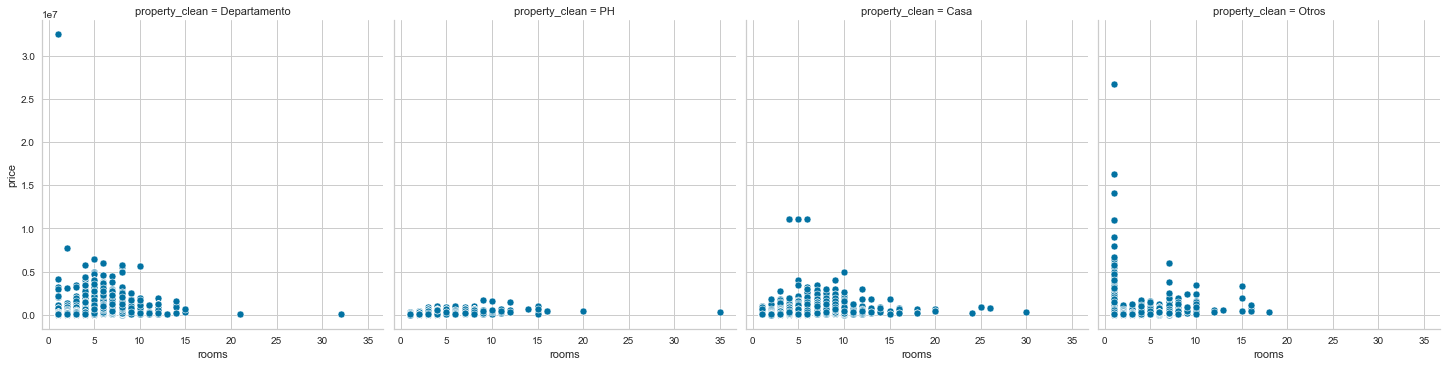

-------------------------------------------------------------------------------------------------------------------- 

Relación entre `bedrooms` y `price`: 



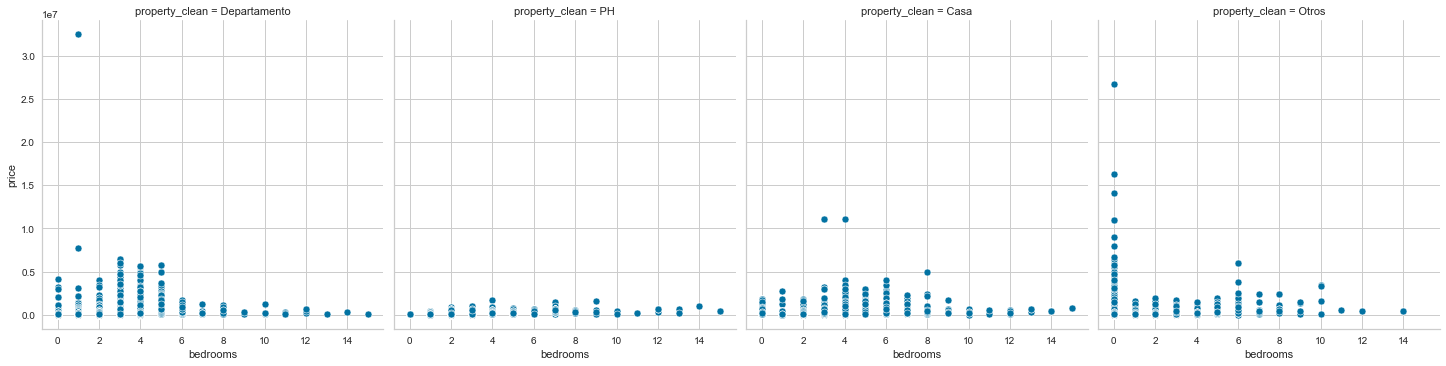

-------------------------------------------------------------------------------------------------------------------- 

Relación entre `bathrooms` y `price`: 



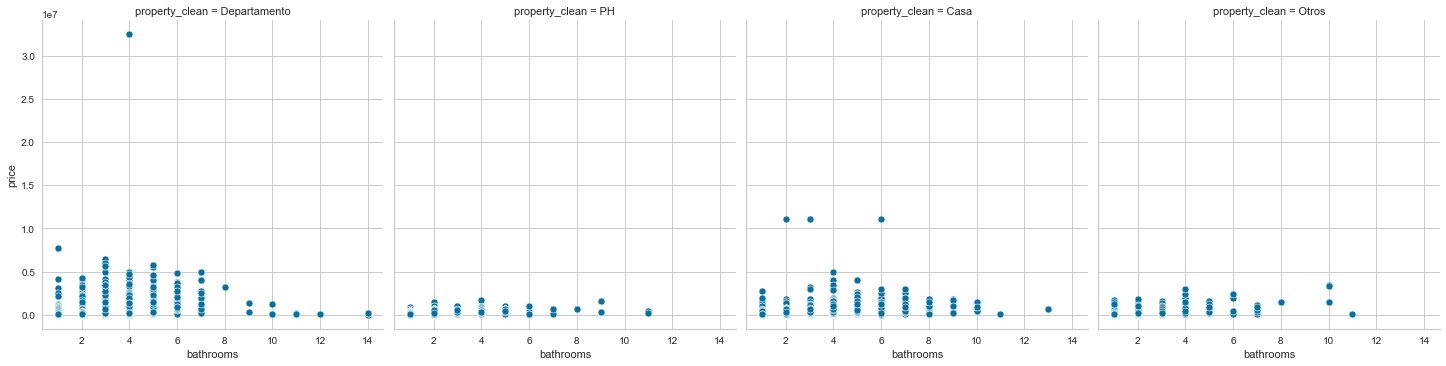

-------------------------------------------------------------------------------------------------------------------- 

Relación entre `surface_total` y `price`: 



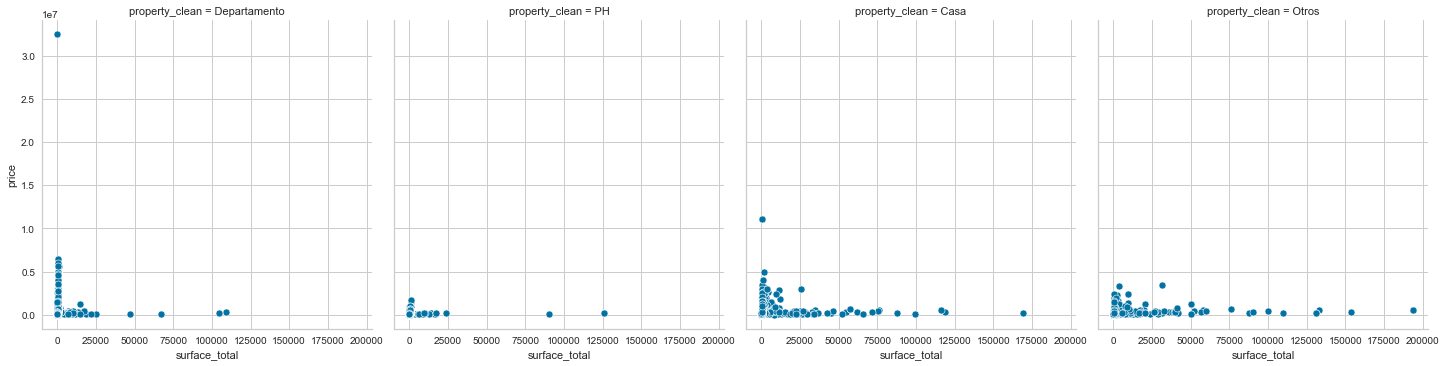

-------------------------------------------------------------------------------------------------------------------- 

Relación entre `surface_covered` y `price`: 



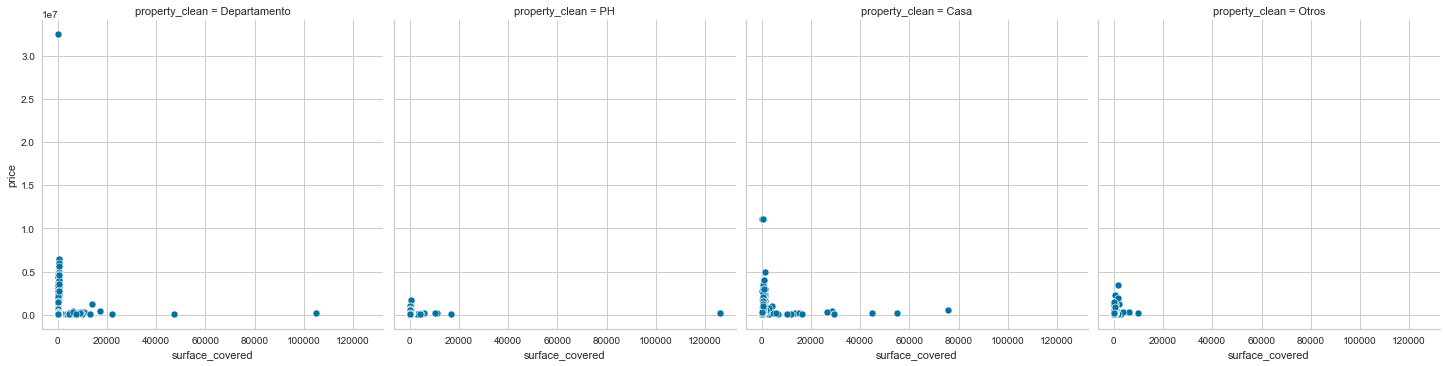

-------------------------------------------------------------------------------------------------------------------- 



In [30]:
for col in numerical_col:
    print(f'Relación entre `{col}` y `price`: \n')
    sns.relplot(data = prop, x = col, y = 'price', kind = 'scatter', col = 'property_clean')
    plt.show()
    print('-------------------------------------------------------------------------------------------------------------------- \n')

De acuerdo al analisis anterior, podemos decir que no existe una relacion lineal de las variables con `price`, discriminadas segun `property_clean`

Text(0.5, 1.0, 'Correlacion entre variables numericas')

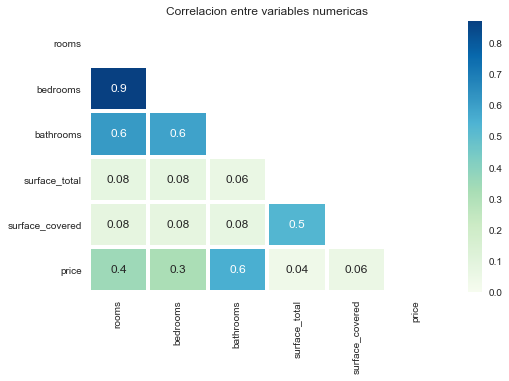

In [31]:
# Calculo de la correlacion entre variables numericas
corr = prop.corr()
# Mascara para visualizar unicamente el triangulo inferior del heatmap
mask = np.triu(corr)

plt.figure(figsize = (8, 5))
sns.heatmap(corr, annot = True, fmt = '.1g', vmin = 0,linecolor = 'w', linewidths = 3, 
            mask = mask, cmap = 'GnBu', annot_kws = {'size': 12})
plt.title('Correlacion entre variables numericas')

In [32]:
VIF = calculate_vif(data = prop[numerical_col].dropna())
VIF

,feature,VIF
0,rooms,29.227669
1,bedrooms,27.479433
2,bathrooms,6.679048
3,surface_total,1.390186
4,surface_covered,1.395564


- Se puede observar que la variable `bathrooms` es la que presenta mayor correlacion con la variable `price`
- Existe una alta correlacion entre `rooms` y `bedrooms`. 
- En el calculo del VIF (variance inflation factor), podemos ver que existen problemas de multicolinealidad entre `rooms`, `bedrooms` y `bathrooms` (considerando VIF mayor  5).

Con la idea de, en principio, no eliminar variables, al finalizar el EDA se concluira en que variables se tendran en cuenta para la construccion de los modelos de ML

#### 2) CATEGORICA VS. CONTINUA

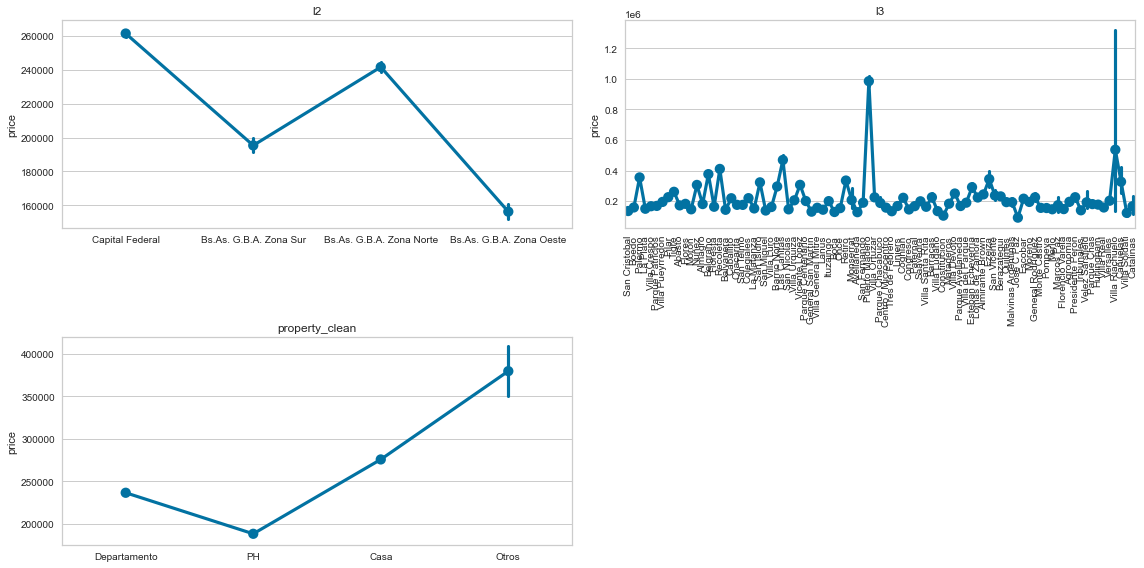

In [33]:
a = 2 # Numero de filas
b = 2 # Numero de columnas
c = 1 # Iniciador del contador

fig = plt.figure(figsize = (16, 8))

for col in categorical_col:
    if len(prop[col].value_counts().index) > 10:
        plt.subplot(a, b, c)
        plt.title(col)
        ax = sns.pointplot(data = prop, x = col, y = 'price')
        ax.set(xlabel = None)
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
        c = c + 1
    else:
        plt.subplot(a, b, c)
        plt.title(col)
        ax = sns.pointplot(data = prop, x = col, y = 'price')
        ax.set(xlabel = None)
        c = c + 1
    
plt.tight_layout()
plt.show()

En funcion de lo que se puede observar en el pointplot, en general, los intervalos de cofianza para cada una de las clases de las variables representadas se mantienen en rangos chicos, lo que es deseable a la hora de querer estimar o inferir la media poblacional de nuestros datos.

# 1) TRANSFORMACION DE DATOS

### IMPUTACION DE VALORES FALTANTES

Debido a la gran cantidad de datos missing y a que la eliminacion de estos implicaria una gran disminucion de la cantidad de observaciones, es que se procedera a imputar los valores de tipo NaN.

In [34]:
# Porcentaje de datos NaN (datos missing)
round((prop.isna().sum() / prop.count()) * 100, 1)

l2                  0.0
l3                  0.0
rooms               0.0
bedrooms            0.0
bathrooms           4.2
surface_total      16.3
surface_covered    17.3
price               0.0
property_clean      0.0
dtype: float64

<!--  -->

Si consideramos que, como regla general, cualquier variable que tenga mas de un 20% de datos NaN debe ser eliminada, para este DS, podemos decir que no existe la necesidad de eliminar ningun atributo y que se trabajara sobre estas para la imputacion de valores.

<!--  -->

Lo siguiente que se realizara es analizar la dependencia de la presencia de datos NaN respecto a variables de tipo categoricas

In [35]:
# Creamos una lista con las variables que contienen datos missing
col_nan = [col for col in prop.columns if prop[col].isna().any()]
col_nan

['bathrooms', 'surface_total', 'surface_covered']

VALORES FALTANTES RESPECTO A LA VARIABLE `l2`: 

Analisis variable `bathrooms`


,l2,count_na_bathrooms,peso
0,Bs.As. G.B.A. Zona Norte,729,0.52
1,Bs.As. G.B.A. Zona Oeste,957,0.68
2,Bs.As. G.B.A. Zona Sur,1749,1.24
3,Capital Federal,2522,1.79


None 



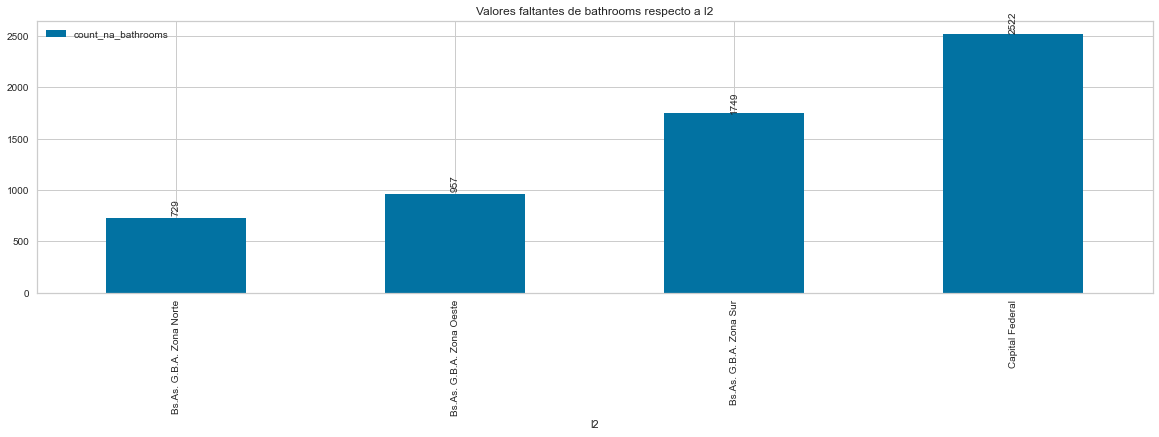



Analisis variable `surface_total`


,l2,count_na_surface_total,peso
0,Bs.As. G.B.A. Zona Norte,1964,1.56
1,Bs.As. G.B.A. Zona Oeste,3561,2.82
2,Bs.As. G.B.A. Zona Sur,5633,4.47
3,Capital Federal,9369,7.43


None 



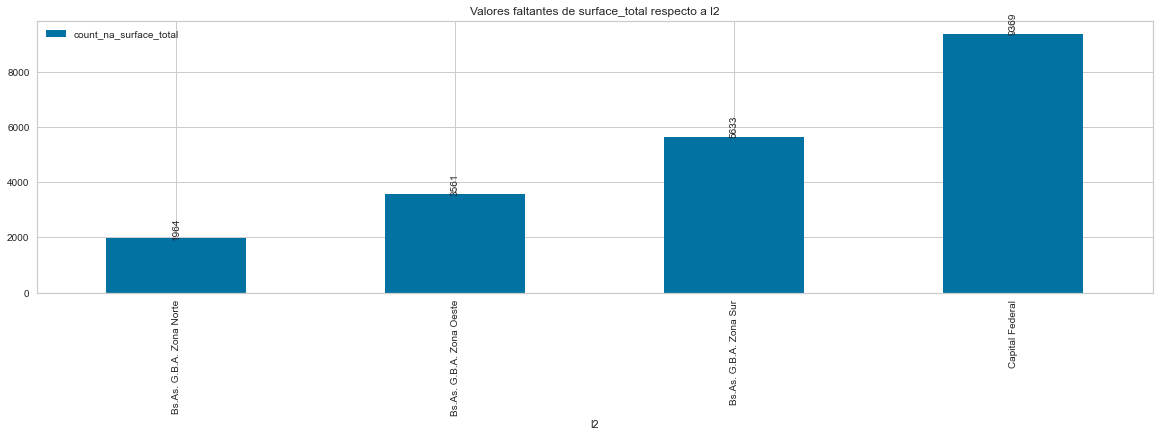



Analisis variable `surface_covered`


,l2,count_na_surface_covered,peso
0,Bs.As. G.B.A. Zona Norte,2172,1.74
1,Bs.As. G.B.A. Zona Oeste,3705,2.96
2,Bs.As. G.B.A. Zona Sur,5871,4.70
3,Capital Federal,9866,7.89


None 



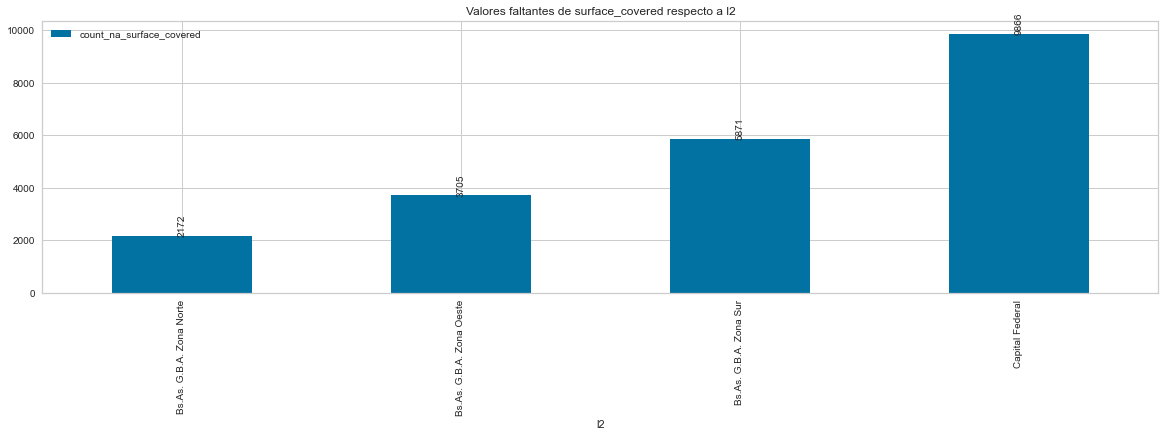



-------------------------------------------------------------------------------------------------------------------------------------------------- 

VALORES FALTANTES RESPECTO A LA VARIABLE `property_clean`: 

Analisis variable `bathrooms`


,property_clean,count_na_bathrooms,peso
0,Casa,1337,0.95
1,Departamento,2696,1.92
2,Otros,1746,1.24
3,PH,178,0.13


None 



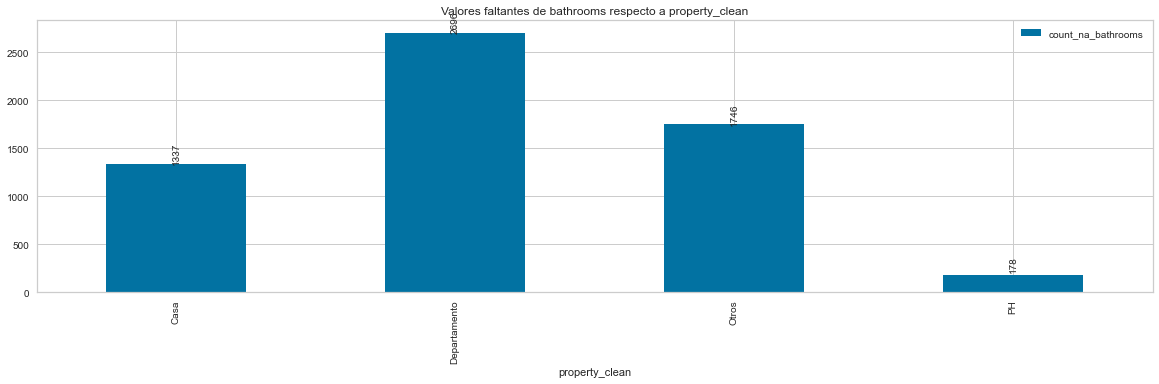



Analisis variable `surface_total`


,property_clean,count_na_surface_total,peso
0,Casa,4917,3.90
1,Departamento,13577,10.76
2,Otros,1904,1.51
3,PH,129,0.10


None 



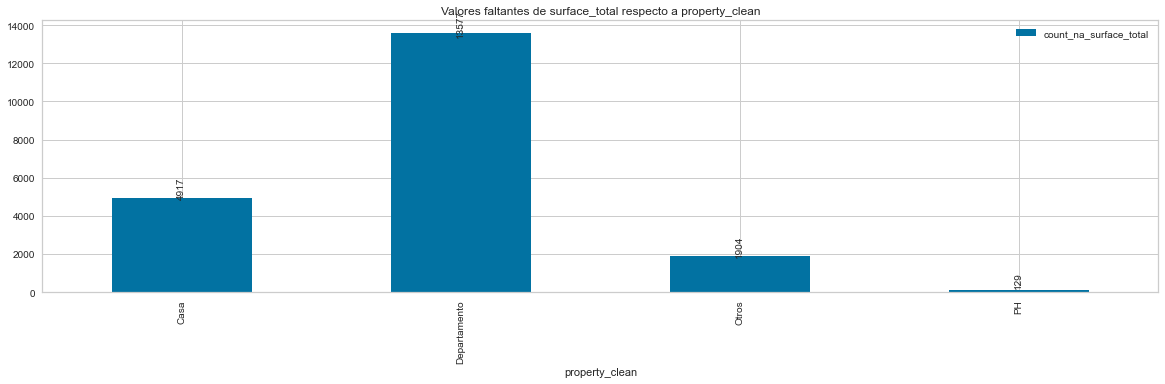



Analisis variable `surface_covered`


,property_clean,count_na_surface_covered,peso
0,Casa,4865,3.89
1,Departamento,13889,11.11
2,Otros,2705,2.16
3,PH,155,0.12


None 



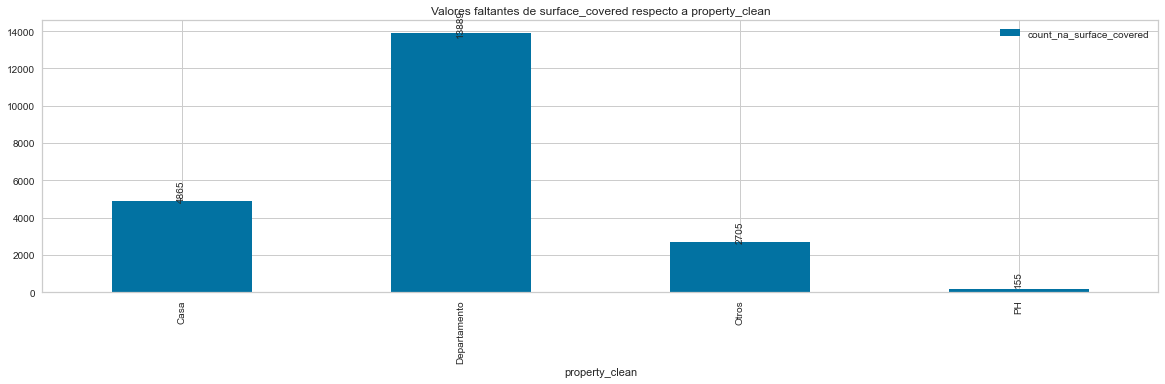



-------------------------------------------------------------------------------------------------------------------------------------------------- 



In [36]:
# Lista de variables a analizar datos NaN
var_j = col_nan
# Lista de variables de tipo categorica
var_i = ['l2', 'property_clean']

# Iteracion para la combinacion de variables
for i in var_i:
    print(f'VALORES FALTANTES RESPECTO A LA VARIABLE `{i}`: \n')
    for j in var_j:
        print(f'Analisis variable `{j}`')
        # Conteo de datos NaN
        data = prop[j].isnull().groupby(prop[i]).sum().astype(int).reset_index(name = f'count_na_{j}')
        # Peso de datos NaN sobre el total de datos de la variable en el DS
        data['peso'] = round((data[f'count_na_{j}'] / prop[j].count()) * 100, 2)
        # Transformacion a DF
        data = pd.DataFrame(data)
        print(display(data), '\n')
        # Grafico de barra para los valores NaN
        plot_na = data.drop(columns = 'peso').plot(kind = 'bar', x = i, figsize = (20, 5))
        # Etiquetas de los datos con orientacion vertical
        for p in plot_na.patches:
            plot_na.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height() + 10), ha = 'center', va = 'center', xytext = (0, 10),
                             textcoords = 'offset pixels', rotation = 90)
        plt.title(f'Valores faltantes de {j} respecto a {i}')
        plt.show()
        print('\n')
    print('-------------------------------------------------------------------------------------------------------------------------------------------------- \n')

Text(0.5, 1.0, 'Correlacion entre variables con datos NaN')

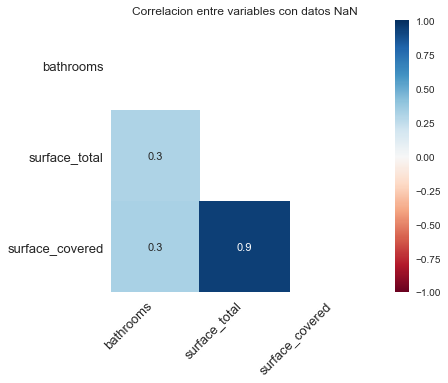

In [37]:
# Mapa de calor de correlaciones entre variables con datos NaN
msno.heatmap(df = prop, figsize = (6, 5), fontsize = 13)
plt.title('Correlacion entre variables con datos NaN')

- La existencia de datos NaN en la variable `bathrooms` puede que tenga relacion segun el tipo de propiedad, ya que vemos que la clase 'Otros', la incluye categorias como Lote, que no necesariamente tenga observaciones en `bathrooms`.
- A su vez, no se puede determinar si existe una dependencia de datos NaN en `bathrooms` en relacion a la variable `l2`.
- Existe una alta relacion por datos NaN entre las variables `surface_covered` y `surface_total`, indicando que puede exista un mecanismo definido de datos missing.

<!--  -->

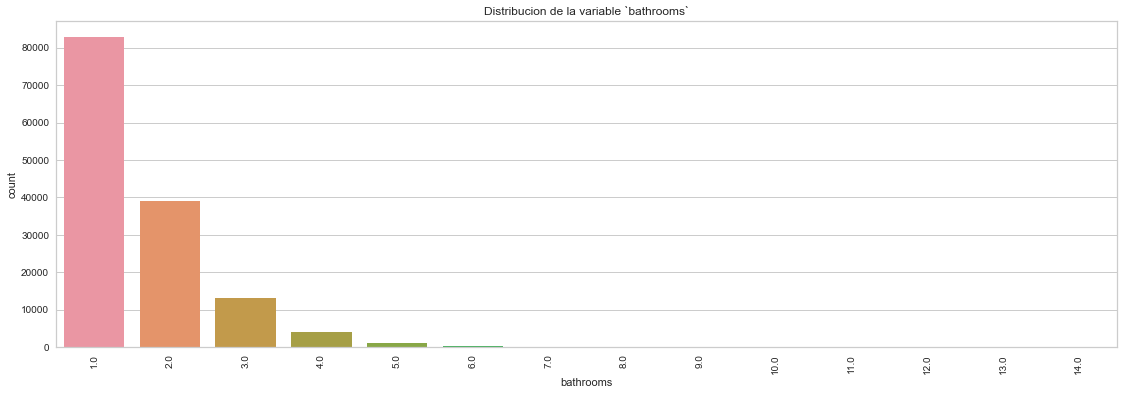

La variable `bathrooms` tiene Sesgo Negativo
--------------------------------------------------------------------------------------------------------------------------------------------- 



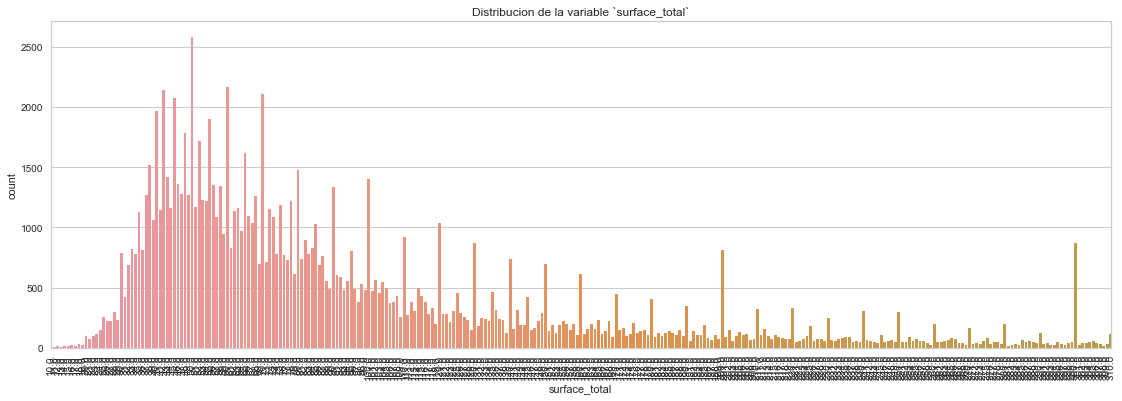

La variable `surface_total` tiene Sesgo Negativo
--------------------------------------------------------------------------------------------------------------------------------------------- 



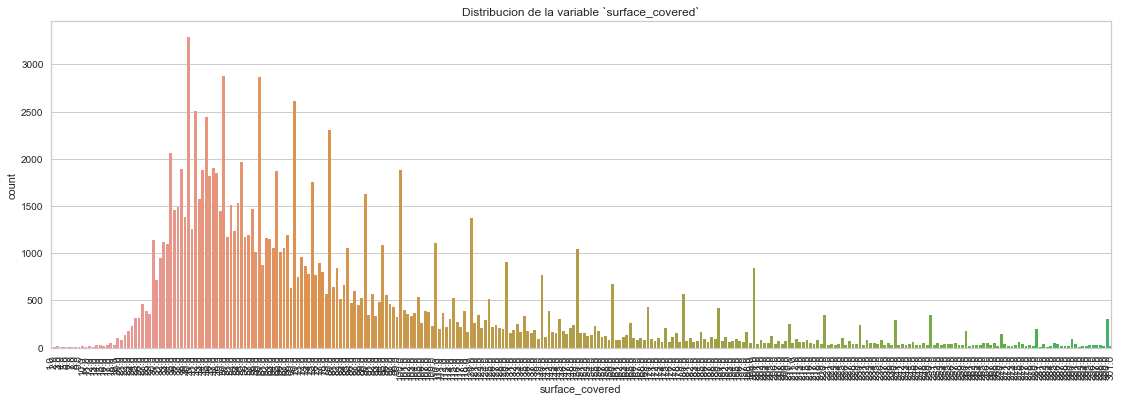

La variable `surface_covered` tiene Sesgo Negativo
--------------------------------------------------------------------------------------------------------------------------------------------- 



In [38]:
# A partir de la lista de variables con datos missing, graficamos la distribucion de las mismas
for col in col_nan:
    plt.figure(figsize = (19, 6))
    if prop[col].max() > 300:
        # Graficamos un countplot para cada variable dentro de `col_nan`
        plot = sns.countplot(data = prop, x = col)
        # Colocamos las etiquetas del eje "x" de manera vertical
        plot.set_xticklabels(plot.get_xticklabels(), rotation = 90)
        plt.title(f'Distribucion de la variable `{col}`')
        plt.xlim(0, 300)
        plt.show()
        # Condicion que arroja el tipo de sesgo que posee la variable
        if prop[col].mean() < prop[col].median():
            print(f'La variable `{col}` tiene Sesgo Positivo')
        else:
            print(f'La variable `{col}` tiene Sesgo Negativo')
        print('--------------------------------------------------------------------------------------------------------------------------------------------- \n')
    else:
        # Graficamos un countplot para cada variable dentro de `col_nan`
        plot = sns.countplot(data = prop, x = col)
        # Colocamos las etiquetas del eje "x" de manera vertical
        plot.set_xticklabels(plot.get_xticklabels(), rotation = 90)
        plt.title(f'Distribucion de la variable `{col}`')
        plt.show()
        # Condicion que arroja el tipo de sesgo que posee la variable
        if prop[col].mean() < prop[col].median():
            print(f'La variable `{col}` tiene Sesgo Positivo')
        else:
            print(f'La variable `{col}` tiene Sesgo Negativo')
        print('--------------------------------------------------------------------------------------------------------------------------------------------- \n')

Debido a la poca cantidad de observaciones de la clase creada `Otros`, se eliminara del DS.

In [39]:
prop = prop.loc[prop['property_clean'] != 'Otros']

In [40]:
prop.shape

(143145, 9)

#### SPLIT

Comenzamos con la definicion de nuestras variables `X` e `y`, y la division entre % de datos para `train` y % de datos para `test`

In [41]:
# Declaramos las variables 'X' e 'y'
X = prop.drop(['price'], axis = 1)
y = prop.price
print(f'X shape: {X.shape}, y shape: {y.shape}')

X shape: (143145, 8), y shape: (143145,)


In [42]:
# Dividimos las variables en test y train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = prop[['l3']])

print(f'X_train shape: {X_train.shape} \n X_test shape: {X_test.shape} \n y_train shape: {y_train.shape} \n y_test shape: {y_test.shape} \n')

X_train shape: (100201, 8) 
 X_test shape: (42944, 8) 
 y_train shape: (100201,) 
 y_test shape: (42944,) 



#### 1) Imputacion de X_train por `property_clean`

In [43]:
# Lista de clases de la variable `property_clean`
propertys = [x for x in X_train.property_clean.unique()]
propertys

['Departamento', 'Casa', 'PH']

In [44]:
# Diccionario de DataFrames, 1 DF por cada elemento encontrado en la lista propertys
propertysdict = {elem: pd.DataFrame() for elem in propertys}

# Creacion de los DF
for key in propertysdict.keys():
    propertysdict[key] = X_train[:][X_train.property_clean == key]
    print(f'{key} shape:', propertysdict[key].shape)

Departamento shape: (75111, 8)
Casa shape: (15110, 8)
PH shape: (9980, 8)


<!--  -->

A partir del diccionario de DataFrames creado anteriormente, iteraremos por cada DataFrame, es decir, por cada tipo de propiedad, e imputaremos los datos missing segun el barrio o `l3`.

Como aun no se han analizado los outliers del DS, eligiremos la "mediana" como metodo de imputacion ya que esta no se ve afectada por la presencia de outliers.

In [45]:
# Para cada DF o tipo de propiedad del dict
for key in propertysdict.keys():
    # Para cada variable con datos missing
    for i in col_nan:
        # Calculo de la mediana por cada l3
        imputer = round(propertysdict[key].groupby(by = 'l3', as_index = False)[i].median(), 0)
        imputer.to_csv(f'Scripts/imputer_{key}_{i}.csv', index = False)
        # Imputacion de la mediana calculada para cuando se encuentre un dato de tipo NaN
        for idx, row in imputer.iterrows():
            # Utilizamos como auxiliar el DF creado como "imputer"
            aux = dict(row)
            # Localizamos l3 y valores nulos de la variable col_nan, luego imputa
            propertysdict[key].loc[(propertysdict[key]['l3'] == aux['l3']) & (propertysdict[key][i].isna()), i] = aux[i]

In [46]:
# Dividir el dict en tantos DataFrames como el dict contiene
X_train_dep = pd.DataFrame.from_dict(data = propertysdict['Departamento'], orient = 'columns')
X_train_casa = pd.DataFrame.from_dict(data = propertysdict['Casa'], orient = 'columns')
X_train_ph = pd.DataFrame.from_dict(data = propertysdict['PH'], orient = 'columns')

# Chequeo de que no hayan datos missing en los DF imputados
print(f'Cantidad de datos missing en X_train Departamento \n {X_train_dep.isna().sum()}:',
     f'Cantidad de datos missing en X_train Casa \n {X_train_casa.isna().sum()}: \n',
     f'Cantidad de datos missing en X_train PH \n {X_train_ph.isna().sum()}: \n')

Cantidad de datos missing en X_train Departamento 
 l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
property_clean     0
dtype: int64: Cantidad de datos missing en X_train Casa 
 l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
property_clean     0
dtype: int64: 
 Cantidad de datos missing en X_train PH 
 l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
property_clean     0
dtype: int64: 



#### 2) Imputacion de X_test

Teniendo en cuenta las imputaciones realizadas en el apartado anterior, imputaremos con el mismo algoritmo el DS de X_test

In [47]:
# Diccionario de DataFrames, 1 DF por cada elemento encontrado en la lista propertys
propertysdict_test = {elem: pd.DataFrame() for elem in propertys}

# Creacion de los DF
for key in propertysdict_test.keys():
    propertysdict_test[key] = X_test[:][X_test.property_clean == key]
    print(f'{key} shape:', propertysdict_test[key].shape)

Departamento shape: (32215, 8)
Casa shape: (6411, 8)
PH shape: (4318, 8)


In [48]:
# Cantidad de datos missing para el DF X_test
X_test.isna().sum()

l2                    0
l3                    0
rooms                 0
bedrooms              0
bathrooms          1246
surface_total      5562
surface_covered    5631
property_clean        0
dtype: int64

<!--  -->

Para la imputacion de datos missing en el DS `X_test`, utilizaremos el mismo algoritmo creado para el DS `X_train`. Para esto, importaremos los csv creados anteriormente, los cuales contienen la informacion para la imputacion de la mediana en datos missing.

In [49]:
# Para cada DF o tipo de propiedad del dict
for key in propertysdict_test.keys():
    # Para cada variable con datos missing
    for i in col_nan:
        # Calculo de la mediana por cada l3
        imputer = pd.read_csv(f'Scripts/imputer_{key}_{i}.csv')
        # Imputacion de la mediana calculada para cuando se encuentre un dato de tipo NaN
        for idx, row in imputer.iterrows():
            # Utilizamos como auxiliar el DF creado como "imputer"
            aux = dict(row)
            # Localizamos l3 y valores nulos de la variable col_nan, luego imputa
            propertysdict_test[key].loc[(propertysdict_test[key]['l3'] == aux['l3']) & (propertysdict_test[key][i].isna()), i] = aux[i]

In [50]:
X_test_dep = pd.DataFrame.from_dict(data = propertysdict_test['Departamento'], orient = 'columns')
X_test_casa = pd.DataFrame.from_dict(data = propertysdict_test['Casa'], orient = 'columns')
X_test_ph = pd.DataFrame.from_dict(data = propertysdict_test['PH'], orient = 'columns')

# Chequeo de que no hayan datos missing en los DF imputados
print(f'Cantidad de datos missing en X_test Departamento \n {X_test_dep.isna().sum()}:',
     f'Cantidad de datos missing en X_test Casa \n {X_test_casa.isna().sum()}: \n',
     f'Cantidad de datos missing en X_test PH \n {X_test_ph.isna().sum()}: \n')

Cantidad de datos missing en X_test Departamento 
 l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
property_clean     0
dtype: int64: Cantidad de datos missing en X_test Casa 
 l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      1
surface_covered    0
property_clean     0
dtype: int64: 
 Cantidad de datos missing en X_test PH 
 l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
property_clean     0
dtype: int64: 



Podemos observar que quedo 1 dato tipo Nan en `surface_total`, el cual sera imputado.

In [51]:
# Concatenacion de los DF por tipo de propiedad del DS X_train
df_train = [X_train_dep, X_train_casa, X_train_ph]
X_train = pd.concat(df_train)
X_train.shape

(100201, 8)

In [52]:
# Concatenacion de los DF por tipo de propiedad del DS X_test
df_test = [X_test_dep, X_test_casa, X_test_ph]
X_test = pd.concat(df_test)
X_test.shape

(42944, 8)

Confirmamos que luego de la concatenacion de los DF, los DS X_train y X_test tienen la misma cantidad de observaciones que al realizar el SPLIT.

<!--  -->

Recien mencionamos que aun contabamos con datos missing en el grupo de datos `X_test`, por lo que se utilizara el algoritmo `SimpleImputer` con "mediana" como estrategia para finalizar las imputaciones.

In [53]:
# Creamos el algoritmo, colocandole el nombre imputer, y entrenamos
imputer = SimpleImputer().fit(X_test[numerical_col])
# Transformacion del DS para la imputacion de los datos
X_test.loc[:, numerical_col] = imputer.transform(X_test[numerical_col])

In [54]:
# Datos missing del DS
X_test.isna().sum()

l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
property_clean     0
dtype: int64

Finalmente, terminamos de realizar las imputaciones y nuestro DS completo ya no contiene datos missing.

Realizaremos un countplot de las features imputadas para corroborar que la distribucion de estas, luego de las imputaciones, no se haya modificado.

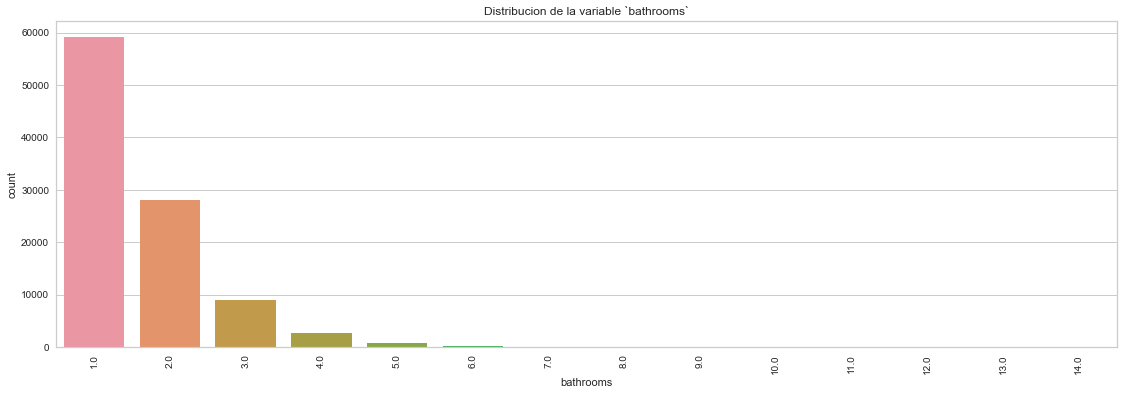

La variable `bathrooms` tiene Sesgo Negativo
--------------------------------------------------------------------------------------------------------------------------------------------- 



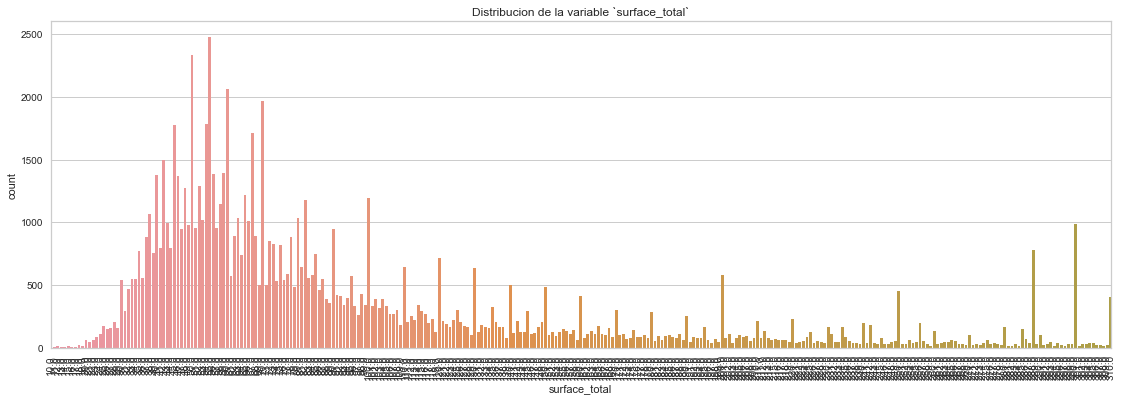

La variable `surface_total` tiene Sesgo Negativo
--------------------------------------------------------------------------------------------------------------------------------------------- 



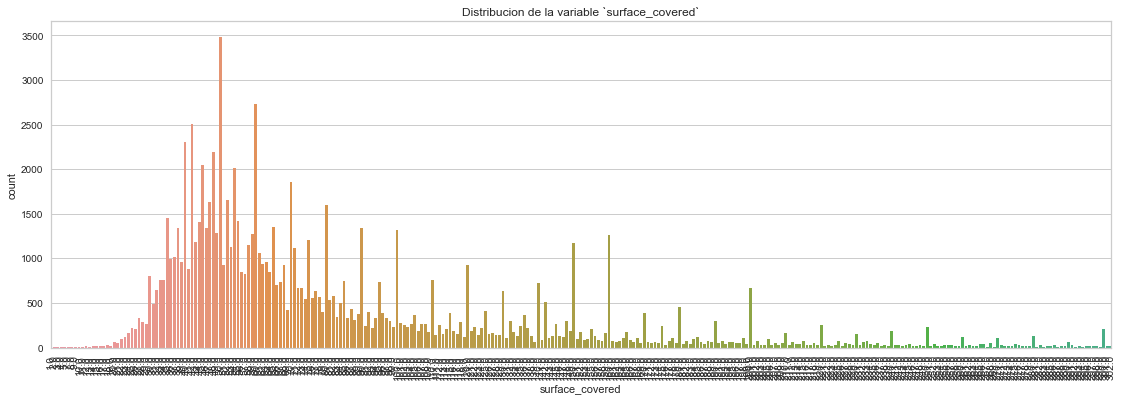

La variable `surface_covered` tiene Sesgo Negativo
--------------------------------------------------------------------------------------------------------------------------------------------- 



In [55]:
# A partir de la lista de variables con datos missing, graficamos la distribucion de las mismas
for col in col_nan:
    plt.figure(figsize = (19, 6))
    if X_train[col].max() > 300:
        # Graficamos un countplot para cada variable dentro de `col_nan`
        plot = sns.countplot(data = X_train, x = col)
        # Colocamos las etiquetas del eje "x" de manera vertical
        plot.set_xticklabels(plot.get_xticklabels(), rotation = 90)
        plt.title(f'Distribucion de la variable `{col}`')
        plt.xlim(0, 300)
        plt.show()
        # Condicion que arroja el tipo de sesgo que posee la variable
        if X_train[col].mean() < X_train[col].median():
            print(f'La variable `{col}` tiene Sesgo Positivo')
        else:
            print(f'La variable `{col}` tiene Sesgo Negativo')
        print('--------------------------------------------------------------------------------------------------------------------------------------------- \n')
    else:
        # Graficamos un countplot para cada variable dentro de `col_nan`
        plot = sns.countplot(data = X_train, x = col)
        # Colocamos las etiquetas del eje "x" de manera vertical
        plot.set_xticklabels(plot.get_xticklabels(), rotation = 90)
        plt.title(f'Distribucion de la variable `{col}`')
        plt.show()
        # Condicion que arroja el tipo de sesgo que posee la variable
        if X_train[col].mean() < X_train[col].median():
            print(f'La variable `{col}` tiene Sesgo Positivo')
        else:
            print(f'La variable `{col}` tiene Sesgo Negativo')
        print('--------------------------------------------------------------------------------------------------------------------------------------------- \n')

Las distribuciones no cambiaron, por lo que podemos decir que las imputaciones fueron realizadas de manera correcta.

### DETECCION Y ELIMINACION DE OUTLIERS

Al principio del notebook, se mostro que las variables numericas contienen gran cantidad de outliers. Como la presencia de estos puede deberse a error de tipeo, situaciones contextuales, errores de medicion, etc., se trataran con el objetivo de que el modelo de ML pueda aprender de manera correcta de nuestros datos.

En funcion de esto, como ninguna de las variables numericas tiene una distribucion normal, debemos detectar los valores atipicos calculando el IQR.

#### 1) X_train

In [56]:
# Para cada DF o tipo de propiedad del dict
for key in propertysdict.keys():
    # Para cada variable numerica
    for i in numerical_col:
        # Calculo del cuartil 1
        Q1 = propertysdict[key][i].quantile(0.25)
        # Calculo del cuartil 3
        Q3 = propertysdict[key][i].quantile(0.75)
        # Calculo del rango intercuartilico
        IQR = Q3 - Q1
        # Limite inferior de la variable
        LI = (Q1 - 1.5 * IQR)
        # Limite superior de la variable
        LS = (Q3 + 1.5 * IQR)
        # Generar un archivo json para guardar el valor LI
        li_file = open(f'Scripts/LI_{key}_{i}.json', 'w')
        li_file = json.dump(LI, li_file)
        # Generar un archivo json para guardar el valor LS
        ls_file = open(f'Scripts/LS_{key}_{i}.json', 'w')
        ls_file = json.dump(LS, ls_file)
        LI = json.load(open(f'Scripts/LI_{key}_{i}.json', 'r'))
        LS = json.load(open(f'Scripts/LS_{key}_{i}.json', 'r'))
        # Creamos columnas binarias para la identificacion de outliers por cada variable analizada
        propertysdict[key][f'{i}_outlier'] = propertysdict[key][i].apply(lambda x: 0 if LI <= x <= LS else 1)

In [57]:
# Dividir el dict en tantos DataFrames como el dict contiene
X_train_dep = pd.DataFrame.from_dict(data = propertysdict['Departamento'], orient = 'columns')
X_train_casa = pd.DataFrame.from_dict(data = propertysdict['Casa'], orient = 'columns')
X_train_ph = pd.DataFrame.from_dict(data = propertysdict['PH'], orient = 'columns')

In [58]:
# Lista de variables con outliers
col_outlier = [col for col in X_train_dep.columns if col.endswith('outlier')]
col_outlier

['rooms_outlier',
 'bedrooms_outlier',
 'bathrooms_outlier',
 'surface_total_outlier',
 'surface_covered_outlier']

In [59]:
X_train = pd.concat(df_train)
print(f'Cantidad de observaciones de `X_train`: {len(X_train)}')

Cantidad de observaciones de `X_train`: 100201


In [60]:
# Eliminacion de datos outliers
X_train = X_train[X_train['rooms_outlier'] == 0]
X_train = X_train[X_train['bedrooms_outlier'] == 0]
X_train = X_train[X_train['bathrooms_outlier'] == 0]
X_train = X_train[X_train['surface_covered_outlier'] == 0]
X_train = X_train[X_train['surface_total_outlier'] == 0]

In [61]:
print(f'Cantidad de observaciones de `X_train`: {len(X_train)}')

Cantidad de observaciones de `X_train`: 87544


Se procedio a eiliminar todas aquellas observaciones clasificadas como outliers, equivalente a la eliminacion del 12,5% de observaciones del grupo de datos `X_train`.

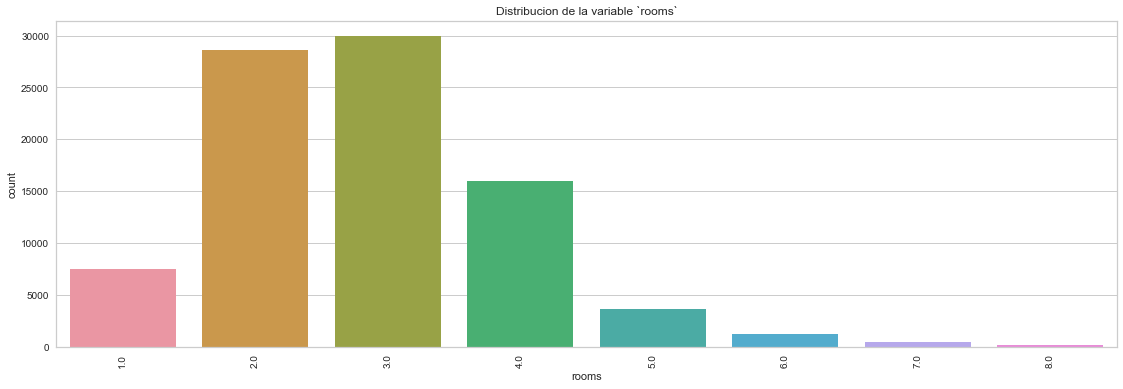

La variable `rooms` tiene Sesgo Positivo
--------------------------------------------------------------------------------------------------------------------------------------------- 



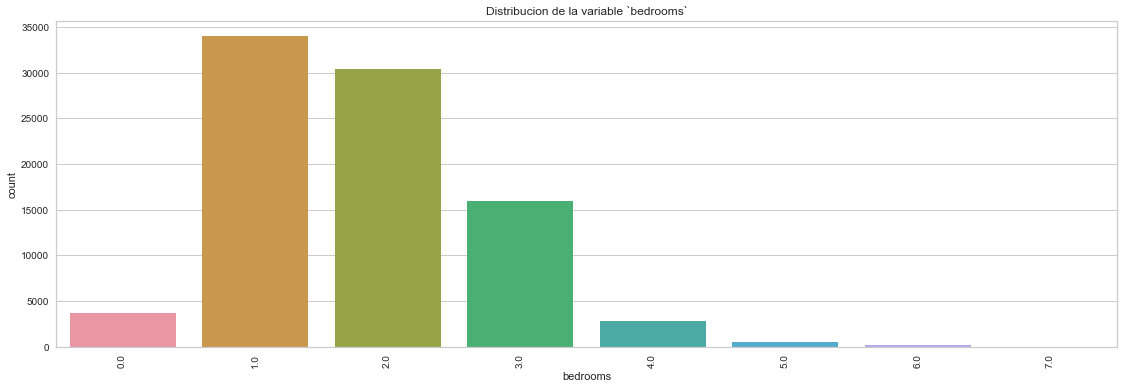

La variable `bedrooms` tiene Sesgo Positivo
--------------------------------------------------------------------------------------------------------------------------------------------- 



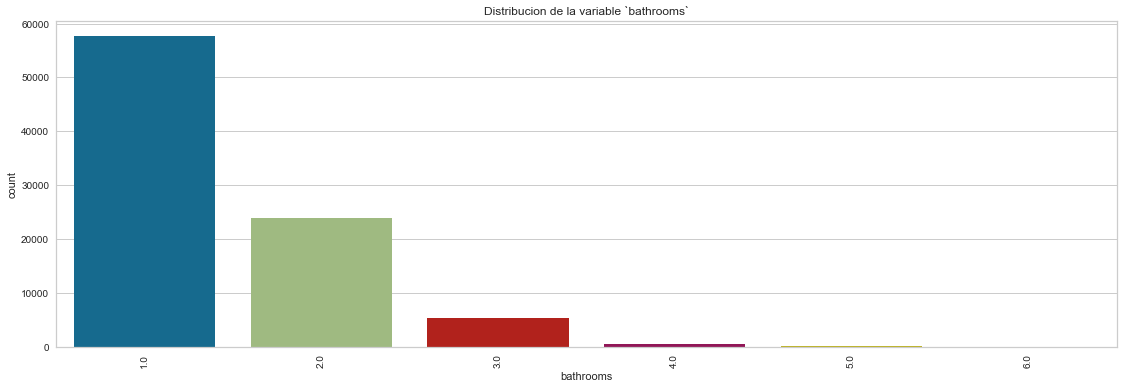

La variable `bathrooms` tiene Sesgo Negativo
--------------------------------------------------------------------------------------------------------------------------------------------- 



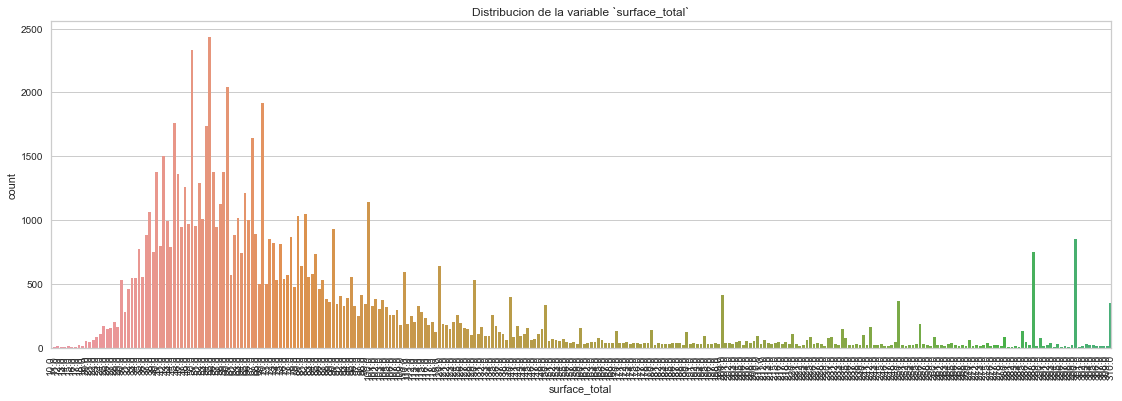

La variable `surface_total` tiene Sesgo Negativo
--------------------------------------------------------------------------------------------------------------------------------------------- 



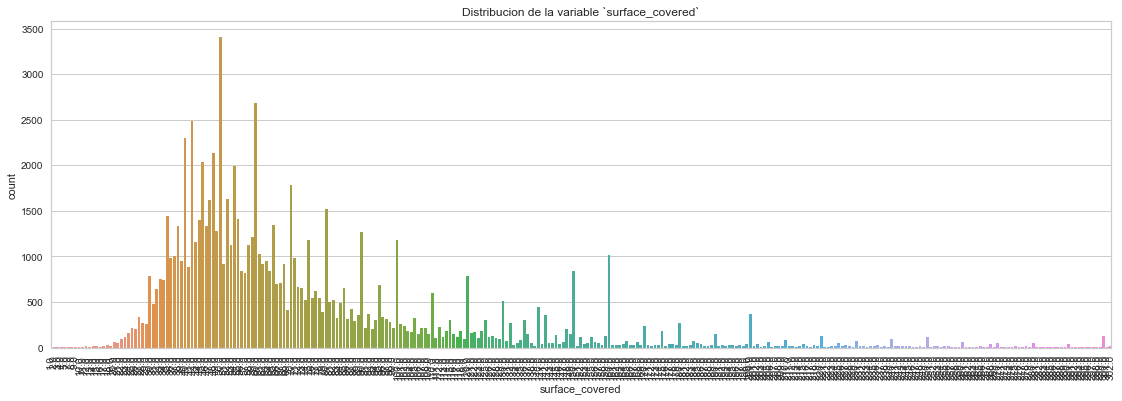

La variable `surface_covered` tiene Sesgo Negativo
--------------------------------------------------------------------------------------------------------------------------------------------- 



In [62]:
# A partir de la lista de variables numericas, graficamos la distribucion de las mismas
for col in numerical_col:
    plt.figure(figsize = (19, 6))
    if X_train[col].max() > 300:
        # Graficamos un countplot para cada variable dentro de `col_nan`
        plot = sns.countplot(data = X_train, x = col)
        # Colocamos las etiquetas del eje "x" de manera vertical
        plot.set_xticklabels(plot.get_xticklabels(), rotation = 90)
        plt.title(f'Distribucion de la variable `{col}`')
        plt.xlim(0, 300)
        plt.show()
        # Condicion que arroja el tipo de sesgo que posee la variable
        if X_train[col].mean() < X_train[col].median():
            print(f'La variable `{col}` tiene Sesgo Positivo')
        else:
            print(f'La variable `{col}` tiene Sesgo Negativo')
        print('--------------------------------------------------------------------------------------------------------------------------------------------- \n')
    else:
        # Graficamos un countplot para cada variable dentro de `col_nan`
        plot = sns.countplot(data = X_train, x = col)
        # Colocamos las etiquetas del eje "x" de manera vertical
        plot.set_xticklabels(plot.get_xticklabels(), rotation = 90)
        plt.title(f'Distribucion de la variable `{col}`')
        plt.show()
        # Condicion que arroja el tipo de sesgo que posee la variable
        if X_train[col].mean() < X_train[col].median():
            print(f'La variable `{col}` tiene Sesgo Positivo')
        else:
            print(f'La variable `{col}` tiene Sesgo Negativo')
        print('--------------------------------------------------------------------------------------------------------------------------------------------- \n')

#### 2) X_test

In [63]:
# Para cada DF o tipo de propiedad del dict
for key in propertysdict_test.keys():
    # Para cada variable numerica
    for i in numerical_col:
        LI = json.load(open(f'Scripts/LI_{key}_{i}.json', 'r'))
        LS = json.load(open(f'Scripts/LS_{key}_{i}.json', 'r'))
        # Creamos columnas binarias para la identificacion de outliers por cada variable analizada
        propertysdict_test[key][f'{i}_outlier'] = propertysdict_test[key][i].apply(lambda x: 0 if LI <= x <= LS else 1)

In [64]:
# Dividir el dict en tantos DataFrames como el dict contiene
X_test_dep = pd.DataFrame.from_dict(data = propertysdict_test['Departamento'], orient = 'columns')
X_test_casa = pd.DataFrame.from_dict(data = propertysdict_test['Casa'], orient = 'columns')
X_test_ph = pd.DataFrame.from_dict(data = propertysdict_test['PH'], orient = 'columns')

In [65]:
X_test = pd.concat(df_test)
print(f'Cantidad de observaciones de `X_train`: {len(X_test)}')

Cantidad de observaciones de `X_train`: 42944


In [66]:
X_test.shape

(42944, 13)

In [67]:
X_test = X_test[X_test['rooms_outlier'] == 0]
X_test = X_test[X_test['bedrooms_outlier'] == 0]
X_test = X_test[X_test['bathrooms_outlier'] == 0]
X_test = X_test[X_test['surface_covered_outlier'] == 0]
X_test = X_test[X_test['surface_total_outlier'] == 0]

In [68]:
print(f'Cantidad de observaciones de `X_train`: {len(X_test)}')

Cantidad de observaciones de `X_train`: 37612


Se procedio a eiliminar todas aquellas observaciones clasificadas como outliers, equivalente a la eliminacion del 12,9% de observaciones del grupo de datos `X_test`.

Como ultimo analisis de variables, verificaremos si la variable `l2` y `l3` son similares en el sentido de la informacion que pueden aportar al modelo:

In [69]:
# Prueba de chi2 para l2 y l3
cross = pd.crosstab(prop['l2'], prop['l3'])
c, p, dof, expected = chi2_contingency(cross)
print(p)

0.0


El resultado nos arroja un valor de `p` igual a 0, indicando que existen una plena dependencia entre ambas variables, lo que podemos interpretar tambien como que ambas variables nos aportaran la misma informacion al modelo. Con esto, procedemos a eliminar `l3`.

In [70]:
X_train.drop('l3', axis = 1, inplace = True)
X_test.drop('l3', axis = 1, inplace = True)

In [71]:
X_train.drop(X_train[col_outlier], axis = 1, inplace = True)
X_test.drop(X_test[col_outlier], axis = 1, inplace = True)

print(f'X_train: {X_train.shape} \n X_test: {X_test.shape}')

X_train: (87544, 7) 
 X_test: (37612, 7)


<!--  -->

### ENCODING

Como los modelos de ML unicamente interpretan o aprenden de datos numericos y no de datos tipo "string", se codificaran todas aquellas variables que son consideradas como categoricas, con el objetivo de poder considerarlas dentro de nuestro modelo de ML.

In [72]:
# Creacion de varialbes dummies para X_train
X_train_enc = pd.get_dummies(data = X_train, columns = ['l2', 'property_clean'])
X_train_enc.head(3)

,rooms,bedrooms,bathrooms,surface_total,surface_covered,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Capital Federal,property_clean_Casa,property_clean_Departamento,property_clean_PH
65476,1.0,1.0,1.0,35.0,31.0,0,0,0,1,0,1,0
67158,2.0,1.0,1.0,60.0,60.0,1,0,0,0,0,1,0
17200,2.0,1.0,1.0,50.0,50.0,1,0,0,0,0,1,0


In [73]:
# Creacion de varialbes dummies para X_test
X_test_enc = pd.get_dummies(data = X_test, columns = ['l2', 'property_clean'])
X_test_enc.head(3)

,rooms,bedrooms,bathrooms,surface_total,surface_covered,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Capital Federal,property_clean_Casa,property_clean_Departamento,property_clean_PH
121696,2.0,1.0,1.0,43.0,41.0,1,0,0,0,0,1,0
8917,1.0,1.0,1.0,60.0,36.0,0,0,0,1,0,1,0
144069,3.0,2.0,2.0,84.0,75.0,1,0,0,0,0,1,0


<!--  -->

### ESCALADO DE LOS DATOS

Las variables numericas que posee nuestro DS, poseen unidades de medida o valores que diferen mucho entre si, es decir, que los valores maximos y minimos para cada variable pueden ser interpretados de manera diferente, dependiendo de la variable en estudio. Para evitar este problema en la interpretabilidad de los datos, estos se escalan o se normalizan de manera tal de poder disponer de datos con las mismas unidades de medida o rangos y facilitar la construccion del modelo de ML.

In [74]:
# Construimos el scaler en funcion de X_train
scaler = RobustScaler().fit(X_train_enc[numerical_col])

In [75]:
# Transformacion de los datos para X_train
X_train_enc.loc[:, numerical_col] = scaler.transform(X_train_enc[numerical_col])

X_train_enc.head(3)

,rooms,bedrooms,bathrooms,surface_total,surface_covered,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Capital Federal,property_clean_Casa,property_clean_Departamento,property_clean_PH
65476,-2.0,-1.0,0.0,-0.611111,-0.674419,0,0,0,1,0,1,0
67158,-1.0,-1.0,0.0,-0.148148,0.000000,1,0,0,0,0,1,0
17200,-1.0,-1.0,0.0,-0.333333,-0.232558,1,0,0,0,0,1,0


In [76]:
# Transformacion de los datos para X_test
X_test_enc.loc[:, numerical_col] = scaler.transform(X_test_enc[numerical_col])

X_test_enc.head(3)

,rooms,bedrooms,bathrooms,surface_total,surface_covered,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Capital Federal,property_clean_Casa,property_clean_Departamento,property_clean_PH
121696,-1.0,-1.0,0.0,-0.462963,-0.441860,1,0,0,0,0,1,0
8917,-2.0,-1.0,0.0,-0.148148,-0.558140,0,0,0,1,0,1,0
144069,0.0,0.0,1.0,0.296296,0.348837,1,0,0,0,0,1,0


<!--  -->

Teniendo nuestro DS definido, procedemos a calcular nuevamente el VIF para compararlo con el que salio al comienzo del proyecto:

In [77]:
# Lista con todas las variables numericas del DS
numerical_col_2 = X_train_enc.select_dtypes(include = 'number').columns.to_list()
numerical_col_2

['rooms',
 'bedrooms',
 'bathrooms',
 'surface_total',
 'surface_covered',
 'l2_Bs.As. G.B.A. Zona Norte',
 'l2_Bs.As. G.B.A. Zona Oeste',
 'l2_Bs.As. G.B.A. Zona Sur',
 'l2_Capital Federal',
 'property_clean_Casa',
 'property_clean_Departamento',
 'property_clean_PH']

In [78]:
# Calculo del VIF
VIF = calculate_vif(data = X_train_enc[numerical_col_2])
VIF

,feature,VIF
0,rooms,5.610201
1,bedrooms,4.555912
2,bathrooms,1.681943
3,surface_total,3.397640
4,surface_covered,4.437178
5,l2_Bs.As. G.B.A. Zona Norte,inf
6,l2_Bs.As. G.B.A. Zona Oeste,inf
7,l2_Bs.As. G.B.A. Zona Sur,inf
8,l2_Capital Federal,inf
9,property_clean_Casa,inf


Vemos que, a diferencia de al comienzo del proyecto, el valor VIF de las variables `rooms` y `bedrooms` disminuyeron considerablemente, habiendo arrojado en un principio 29,2 y 27,5, respectivamente. Sin embargo, `rooms` tiene un valor aun por encima de 5, y las variables dummies creadas, tienen valor infinito, por lo que se procedera a eliminar algunas variables para quedarnos con un DS con valores de VIF en lo posible por debajo de 5 en todas sus variables.

In [79]:
numerical_col_3 = X_train_enc.drop(['property_clean_Departamento'], axis = 1).select_dtypes(include = 'number').columns.to_list()
numerical_col_3

['rooms',
 'bedrooms',
 'bathrooms',
 'surface_total',
 'surface_covered',
 'l2_Bs.As. G.B.A. Zona Norte',
 'l2_Bs.As. G.B.A. Zona Oeste',
 'l2_Bs.As. G.B.A. Zona Sur',
 'l2_Capital Federal',
 'property_clean_Casa',
 'property_clean_PH']

In [80]:
# Calculo del VIF
VIF = calculate_vif(data = X_train_enc[numerical_col_3])
VIF

,feature,VIF
0,rooms,5.610201
1,bedrooms,4.555912
2,bathrooms,1.681943
3,surface_total,3.397641
4,surface_covered,4.437216
5,l2_Bs.As. G.B.A. Zona Norte,1.391696
6,l2_Bs.As. G.B.A. Zona Oeste,1.277456
7,l2_Bs.As. G.B.A. Zona Sur,1.497363
8,l2_Capital Federal,1.769029
9,property_clean_Casa,3.258378


In [81]:
X_train_enc.drop(['property_clean_Departamento'], axis = 1, inplace = True)
X_test_enc.drop(['property_clean_Departamento'], axis = 1, inplace = True)

print(f'X_train shape: {X_train_enc.shape} \n X_test shape: {X_test_enc.shape}')

X_train shape: (87544, 11) 
 X_test shape: (37612, 11)


Si bien `property_clean_Departamento` tiene un valor de VIF por encima de 5, es la mejor situacion encontrada para no eliminar tantas variables. Dicho esto, se concluye habiendo eliminado las variables `rooms` y `l2_Bs.As. G.B.A. Zona Norte`.

<!--  -->

Como se eliminaron filas de los grupos de datos de X_train y X_test, se procede a eliminar las mismas observaciones para nuestra variable de salida `price`:

In [82]:
idx = X_train_enc.index
y_train = y_train[idx]

In [83]:
idx = X_test_enc.index
y_test = y_test[idx]

<!--  -->

### MODELO UTILIZADO EN EL SPRINT 01 (Arbol de Decision)

En el Arbol de Decision utilizado en el SPRINT 01 se consideraron los siguientes parametros:

- max_depth = 11
- random_state = 42

Por lo que se utilizaran estos mismos parametros con el DS del SPRINT 02 para comparar resultados.

In [84]:
# Creamos el modelo de Arbol de Decision
regressor_tree = DecisionTreeRegressor(max_depth = 11, random_state = 42)
# Entramiento de los datos
regressor_tree.fit(X_train_enc, y_train)

DecisionTreeRegressor(max_depth=11, random_state=42)

In [85]:
# Predecimos las etiquetas sobre los conjuntos de datos de 'train' y 'test'
y_train_pred_tree = regressor_tree.predict(X_train_enc)
y_test_pred_tree = regressor_tree.predict(X_test_enc)

In [86]:
# Calculamos las metricas elegidas para X_train
RMSE = mean_squared_error(y_train, y_train_pred_tree, squared = False)
r2 = r2_score(y_train, y_train_pred_tree)

print(f'RMSE: {RMSE} \n r2: {r2}')

RMSE: 78716.58017622515 
 r2: 0.6870353204711923


In [87]:
RMSE = mean_squared_error(y_test, y_test_pred_tree, squared = False)
RMSE

96956.94699414434

<!--  -->

#### CONCLUSIONES MODELO UTILIZADO EN SPRINT 01

En el SPRINT 01 los resultados fueron:

- RMSE = 113446
- r2 = 0.8577

Podemos destacar algunos puntos que pueden justificar la diferencia en los scores del SPRINT 01 vs. SPRINT 02:

1) **Cantidad de datos:** en el SPRINT 01 se tuvieron en cuenta las siguientes premisas para el modelado

    - Selecciona aquellas propiedades en Capital Federal y cuyo tipo de propiedad es Departamento, PH o Casa.
    - Selecciona aquellas propiedades cuya superficie total es menor a 1000 m2 y mayor a 15 m2.
    - Selecciona aquellas propiedades cuya precio es menor 4000000 dólares.
    - Selecciona las columnas `rooms`, `bedrooms`, `bathrooms`, `surface_total`, `surface_covered` y `price`.
    - Descarta aquellas instacias con valores faltantes.
    - Eliminacion de observaciones de `surface_coveed` mayores a `surface_total`
    
    Estas consideraciones implicaron en trabajar con 80276 observciones, contra un total de 125062 actuales, dando una diferencia de un 55% de mayor cantidad de observaciones.
   
2) **Variabilidad de los datos:**

    - Se consideraron mayor cantidad de regiones (`l2`) en el SPRINT 02.
    - No existe un limite de superficie total o cubierta, lo que implica que el modelo del SPRINT 02 tenga mas variabilidad que el 01. Misma situacion con el precio de las viviendas.


3) **Variables consideradas:**

    - Ademas de las limitantes propuestas para el SPRINT 01, no se consideraron variables como Regiones o Tipos de propiedad, limitandolo unicamente al aprendizaje solo con las variables numericas propuestas en el DS incial, situacion contraria al SPRINT 02, en donde se realizaron codificaciones y creacion de variables dummies de las variables categoricas para ser incluidas en el modelado.
    
Considerando lo propuesto anteriormente, podemos decir que:

- Existe una contraposicion en los resultados obtenidos. Por un lado, existe una reduccion del error RMSE con los datos del SPRINT 02. Y por otro, existe tambien una disminucion del r2, es decir, que el modelo tiene menor capacidad para explicar la variabilidad de los datos.
- La reduccion del RMSE impacta de manera positiva, y esto puede deberse, no solo a la mayor cantidad de datos utilizados, sino tambien en la consideracion de variables como tipo de propiedad y ubicacion regional de las propiedades.
- La reduccion del r2 impacta de manera negativa, y esto puede deberse a que tenemos presente un desbalanceo de los datos en funcion a las observaciones por tipo de propiedad, por lo que termina prediciendo mejor algun tipo de propiedad que por sobre los demas. Como la variable de tipo de propiedad no estaba presente en el SPRINT 01, el error de pronosticar mejor un tipo de propiedad que otro no estaba siendo considerada.

# 2) MODELOS AVANZADOS

### 1) RANDOM FOREST

Lo siguiente que haremos es calcular el valor maximo de arboles a entrenar con el objetivo de reducir el costo computacional que requiere el entrenamiento del algoritmo. El calculo indica a partir de que 'n' de arboles a entrenar arroja el mismo r2 para el "out-of-bag score":

In [88]:
# train_scores = [] # Lista vacia de los resultados de cada entrenamiento
# oob_scores = [] # Lista vacia de los resultados de los errores oob

# # Rango de cantidad de arboles a entrenar
# estimator_range = range(1, 700, 25)

# # Entrenado de los arboles
# for n_estimators in estimator_range:
#     modelo = RandomForestRegressor(
#                 n_estimators = n_estimators,
#                 criterion = 'mse',
#                 max_depth = None,
#                 max_features = 'auto',
#                 oob_score = True,
#                 n_jobs = -1,
#                 random_state = 42
#              )
#     modelo.fit(X_train_enc, y_train)
#     train_scores.append(modelo.score(X_train_enc, y_train))
#     oob_scores.append(modelo.oob_score_)
    
# # Grafico de r2 oob vs. cantidad de arboles a entrenar
# fig, ax = plt.subplots(figsize=(10, 7))
# ax.plot(estimator_range, train_scores, label = 'train scores')
# ax.plot(estimator_range, oob_scores, label = 'out-of-bag scores')
# ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
#         marker = 'o', color = 'red', label = 'max score')
# ax.set_ylabel('r2')
# ax.set_xlabel('n_estimators')
# ax.set_title('Evolución del out-of-bag-error vs número árboles')
# plt.legend();
# print(f'Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]} \n')

In [89]:
# Generamos el Random Forest
r_forest = RandomForestRegressor()

In [90]:
# Definicion de los parametros para el GridSearch
params = {
    'n_estimators': [300, 500, 700, 900],
    'criterion': ['mse'],
    'max_depth': [2, 5, 8, 12, 15],
    'oob_score': [True],
    'random_state': [42],
    'n_jobs': [-1],
    'ccp_alpha': [0.001, 0.01]
}

In [91]:
# Definimos el GridSearch para un algoritmo del tipo RandomForest
r_forest_cv = GridSearchCV(estimator = r_forest, param_grid = params, cv = 5, n_jobs = -1)

In [92]:
# Entrenamos el modelo con los parametros definidos
r_forest_cv.fit(X_train_enc, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.001, 0.01], 'criterion': ['mse'],
                         'max_depth': [2, 5, 8, 12, 15],
                         'n_estimators': [300, 500, 700, 900], 'n_jobs': [-1],
                         'oob_score': [True], 'random_state': [42]})

In [93]:
# Mejores parametros de la grilla definida
r_forest_cv.best_params_

{'ccp_alpha': 0.001,
 'criterion': 'mse',
 'max_depth': 15,
 'n_estimators': 700,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 42}

In [94]:
# Resultados de la mejor combinacion de hiperparametros encontrada
scores = pd.DataFrame(r_forest_cv.cv_results_)
scores.sort_values(by = 'rank_test_score').head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_criterion,param_max_depth,param_n_estimators,param_n_jobs,param_oob_score,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
18,132.459366,3.742304,7.062921,1.128774,0.001,mse,15,700,-1,True,42,"{'ccp_alpha': 0.001, 'criterion': 'mse', 'max_...",0.64334,0.539112,0.669034,0.321807,0.161803,0.467019,0.195622,1


In [95]:
# Predecimos la variable objetivo
y_train_pred_rf = r_forest_cv.predict(X_train_enc)
y_test_pred_rf = r_forest_cv.predict(X_test_enc)

In [96]:
# Calculo de los errores para X_train teniendo en cuenta los mejores estimadores
rf = r_forest_cv.best_estimator_

print(f"El MAE en entrenamiento es: {round(mean_absolute_error(y_train, rf.predict(X_train_enc)), 2)}")
print(f"El MAPE en entrenamiento es: {round(mean_absolute_percentage_error(y_train, rf.predict(X_train_enc)), 2) * 100}")
print(f"El RMSE en entrenamiento es: {round(mean_squared_error(y_train, rf.predict(X_train_enc), squared = False), 2)}")
print(f"El R2 en entrenamiento es: {round(rf.score(X_train_enc, y_train), 3)}")

El MAE en entrenamiento es: 34537.86
El MAPE en entrenamiento es: 21.0
El RMSE en entrenamiento es: 71261.73
El R2 en entrenamiento es: 0.744


In [97]:
# Calculo de los errores para X_test teniendo en cuenta los mejores estimadores
print(f"El MAE en prueba es: {round(mean_absolute_error(y_test, rf.predict(X_test_enc)), 2)}")
print(f"El MAPE en prueba es: {round(mean_absolute_percentage_error(y_test, rf.predict(X_test_enc)), 4) * 100}")
print(f"El RMSE en prueba es: {round(mean_squared_error(y_test, rf.predict(X_test_enc), squared = False), 2)}")
print(f"El R2 en prueba es: {round(rf.score(X_test_enc, y_test), 3)}")

El MAE en prueba es: 40996.71
El MAPE en prueba es: 24.59
El RMSE en prueba es: 75855.49
El R2 en prueba es: 0.615


In [98]:
# Creamos un DF de variables e importancia por cada variable
idx = numerical_col_3
feature_importances = pd.DataFrame(r_forest_cv.best_estimator_.feature_importances_ * 100, index = idx, columns = ['Importancia'])

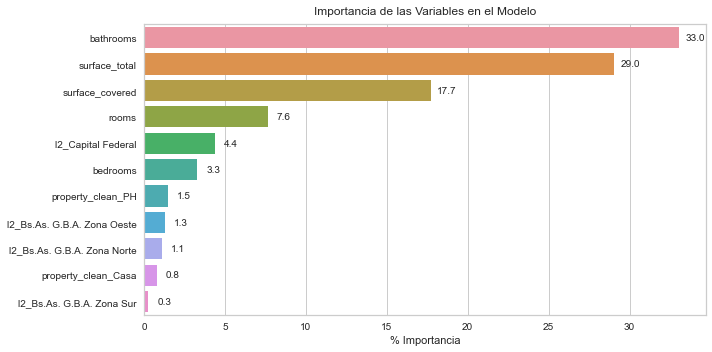

In [99]:
# Grafico de importancia de las variables en el modelo
plt.figure(figsize = (10, 5))
# Grafico
plot = sns.barplot(data = feature_importances,
            x = 'Importancia',
            y = numerical_col_3, 
            order = feature_importances.sort_values(by = 'Importancia', ascending = False).index)
# Colocar etiquetas de datos
for p in plot.patches:
    width = p.get_width()
    plot.text(p.get_width() + 1, p.get_y() + p.get_height() / 2,
             '{:1.1f}'.format(width),
             ha = 'center', va = 'center')
plt.xlabel('% Importancia')
plt.title('Importancia de las Variables en el Modelo', pad = 10)
plt.tight_layout()

Las variables que mas importancia tienen en el modelo son `bathrooms`, `surface_total` y `surface_covered`.

<!--  -->

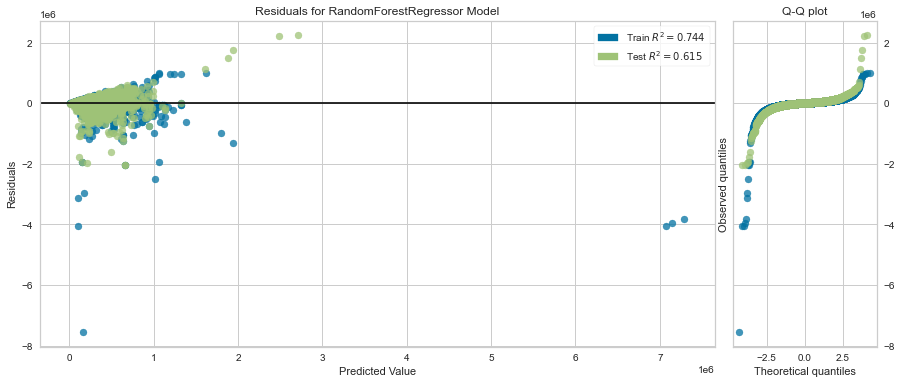

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [100]:
# Visualizacion de los residuales
plt.figure(figsize = (15, 6))
residuals = ResidualsPlot(estimator = rf, hist = False, qqplot = True).fit(X_train_enc, y_train)
residuals.score(X_test_enc, y_test)
residuals.show()

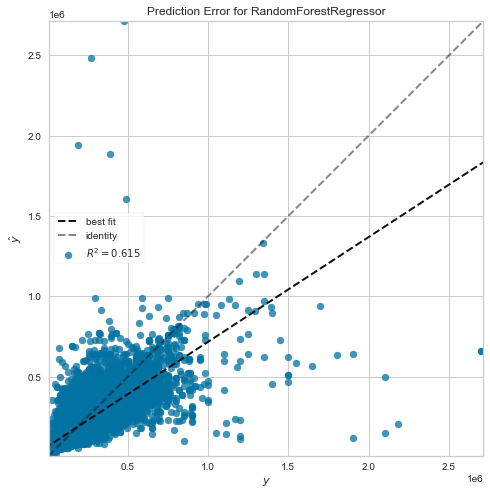

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [101]:
# Visualizacion de la prediccion obtenida vs. la prediccion esperada
plt.figure(figsize = (8, 8))
predictions_error = PredictionError(estimator = rf).fit(X_train_enc, y_train)
predictions_error.score(X_test_enc, y_test)
predictions_error.show()

<!--  -->

### 2) REGRESION LINEAL

#### 2.1) POLINOMICA POR MINIMOS CUADRADOS (OLS)

In [102]:
# Creamos el modelo
poly = PolynomialFeatures(degree = 3).fit(X_train_enc)

In [103]:
# Generamos las variables hasta grado 2 para el conjunto de datos X_train
features_transformed = poly.get_feature_names()
X_train_pol = pd.concat(objs = [pd.DataFrame(poly.transform(X_train_enc), 
                                             columns = features_transformed, index = X_train_enc.index)], axis = 1)
X_train_pol.head()

,1,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x8^3,x8^2 x9,x8^2 x10,x8 x9^2,x8 x9 x10,x8 x10^2,x9^3,x9^2 x10,x9 x10^2,x10^3
65476,1.0,-2.0,-1.0,0.0,-0.611111,-0.674419,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67158,1.0,-1.0,-1.0,0.0,-0.148148,0.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17200,1.0,-1.0,-1.0,0.0,-0.333333,-0.232558,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74002,1.0,-1.0,-1.0,0.0,0.203704,0.302326,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32946,1.0,1.0,0.0,0.0,0.592593,0.930233,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
# Generamos las variables hasta grado 2 para el conjunto de datos X_test
X_test_pol = pd.concat(objs = [pd.DataFrame(poly.transform(X_test_enc), 
                                             columns = features_transformed, index = X_test_enc.index)], axis = 1)
X_test_pol.head()

,1,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x8^3,x8^2 x9,x8^2 x10,x8 x9^2,x8 x9 x10,x8 x10^2,x9^3,x9^2 x10,x9 x10^2,x10^3
121696,1.0,-1.0,-1.0,0.0,-0.462963,-0.441860,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8917,1.0,-2.0,-1.0,0.0,-0.148148,-0.558140,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144069,1.0,0.0,0.0,1.0,0.296296,0.348837,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114040,1.0,0.0,0.0,0.0,-0.259259,-0.255814,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131116,1.0,0.0,0.0,1.0,0.222222,0.465116,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
# Entrenamos el modelo
linear_reg = LinearRegression().fit(X_train_pol, y_train)

# Imprimimos los resultados del modelo para X_train y X_test
print(f'El r2 en entrenamiento es: {linear_reg.score(X_train_pol, y_train)}')
print(f'El r2 en prueba es: {linear_reg.score(X_test_pol, y_test)}')
print(f'El RMSE en entrenamiento es: {mean_squared_error(y_train, linear_reg.predict(X_train_pol), squared = False)}')
print(f'El RMSE en prueba es: {mean_squared_error(y_test, linear_reg.predict(X_test_pol), squared = False)}')

El r2 en entrenamiento es: 0.4114947953738759
El r2 en prueba es: 0.537227534955828
El RMSE en entrenamiento es: 107942.80727429564
El RMSE en prueba es: 83217.78761866431


Text(0.5, 1.0, 'Coeficientes del modelo')

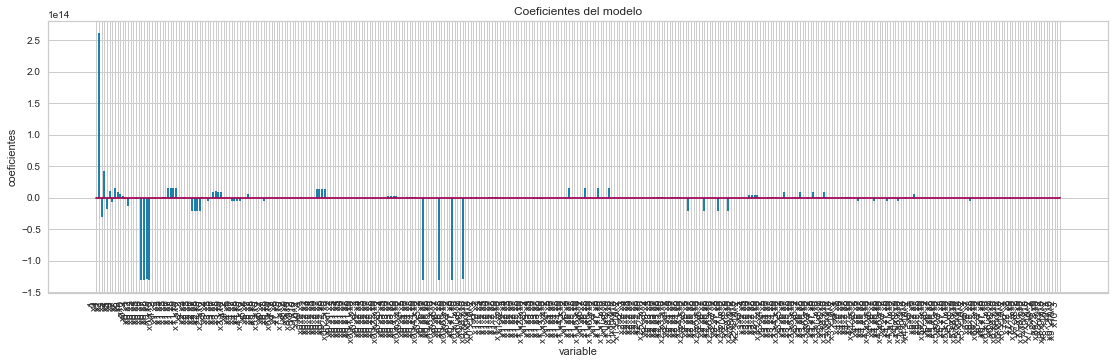

In [106]:
# Graficamos los coeficientes correspondientes a cada variable generada para el modelo
df_coeficientes = pd.DataFrame({'predictor': X_train_pol.columns,'coef': linear_reg.coef_.flatten()})

fig, ax = plt.subplots(figsize = (19, 5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation = 90, ha = 'right', size = 10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo')

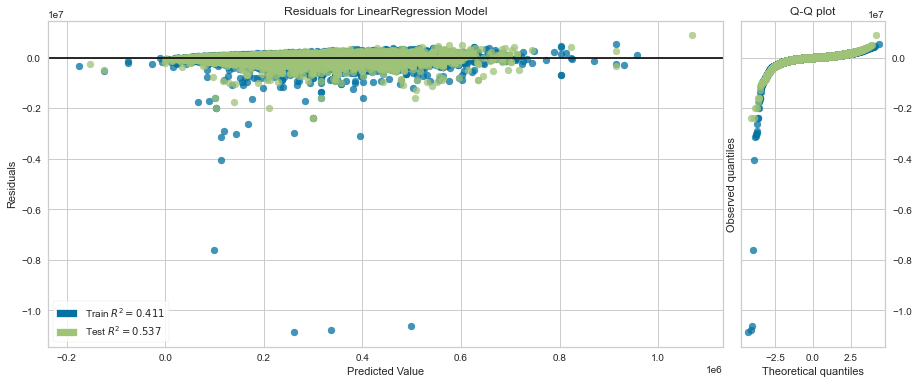

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [107]:
# Visualizacion de los residuales
plt.figure(figsize = (15, 6))
residuals = ResidualsPlot(estimator = linear_reg, hist = False, qqplot = True).fit(X_train_pol, y_train)
residuals.score(X_test_pol, y_test)
residuals.show()

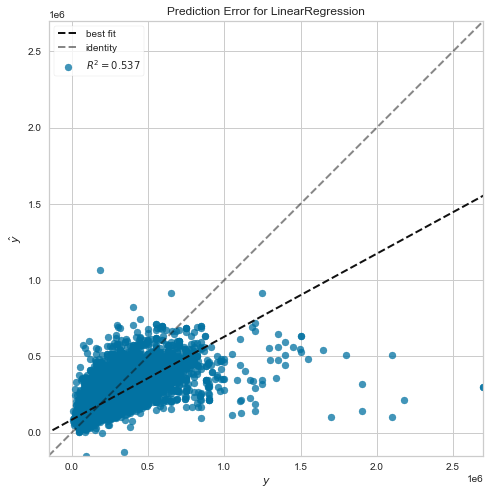

<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [108]:
# Visualizacion de la prediccion obtenida vs. la prediccion esperada
plt.figure(figsize = (8, 8))
prediction_error = PredictionError(estimator = linear_reg).fit(X_train_pol, y_train)
prediction_error.score(X_test_pol, y_test)
prediction_error.show()

<!--  -->

#### 2.2) RIDGE

Aplicamos una regularizacion Ridge, el cual tiene el efecto de reducir de forma proporcional el valor de todos los coeficientes del modelo pero sin que estos lleguen a cero. Esta estrategia se aplica con el objetivo de evitar el overfiting, reducir varianza, atenuar el efecto de correlacion entre predictores y disminuir o minimizar la influencia de los predictores menos relevantes en el modelo.

In [109]:
# Creamos el modelo de regresion lineal con L2
linear_reg_l2 = RidgeCV(alphas = np.logspace(1, 20, 200), fit_intercept = True, normalize = True, store_cv_values = True)

_ = linear_reg_l2.fit(X_train_pol, y_train)

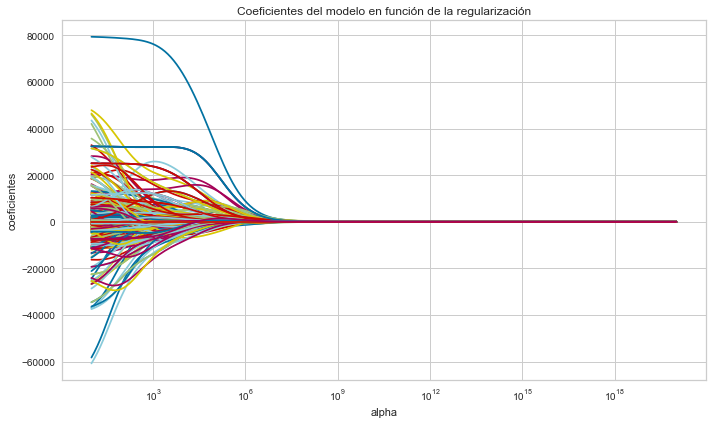

In [122]:
# Grafico de la atenuacion de los coeficientes de los predictores con el aumento de alpha
alphas = linear_reg_l2.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha = alpha, fit_intercept = False, normalize = True)
    modelo_temp.fit(X_train_pol, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.tight_layout()
plt.show()

In [110]:
print(f'Mejor valor de alpha encontrado: {linear_reg_l2.alpha_}')

Mejor valor de alpha encontrado: 10.0


Text(0.5, 1.0, 'Coeficientes del modelo')

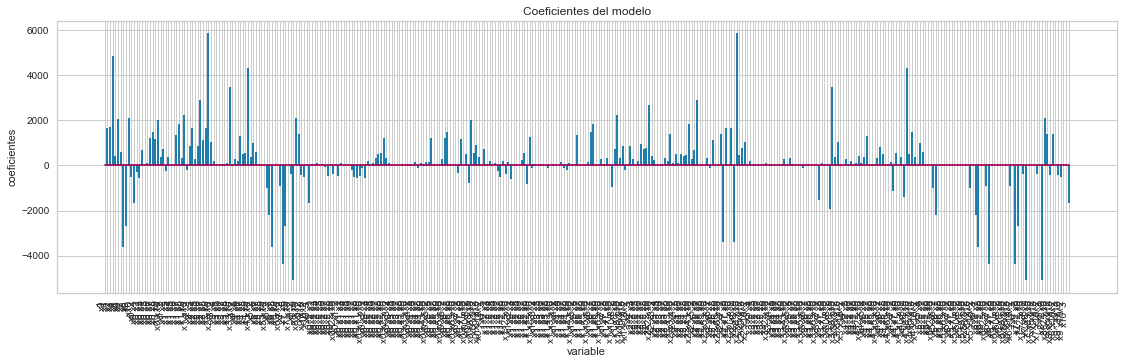

In [111]:
# Graficamos los coeficientes correspondientes a cada variable generada para el modelo
df_coeficientes = pd.DataFrame({'predictor': X_train_pol.columns, 'coef': linear_reg_l2.coef_.flatten()})

fig, ax = plt.subplots(figsize = (19, 5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt = ' ')
plt.xticks(rotation = 90, ha = 'right', size = 10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo')

In [112]:
# Imprimimos los resultados del modelo para X_train y X_test
print(f'El r2 en entrenamiento es: {linear_reg_l2.score(X_train_pol, y_train)}')
print(f'El r2 en prueba es: {linear_reg_l2.score(X_test_pol, y_test)}')
print(f'El RMSE en entrenamiento es: {mean_squared_error(y_train, linear_reg_l2.predict(X_train_pol), squared = False)}')
print(f'El RMSE en prueba es: {mean_squared_error(y_test, linear_reg_l2.predict(X_test_pol), squared = False)}')

El r2 en entrenamiento es: 0.2551969475204042
El r2 en prueba es: 0.34369182518428076
El RMSE en entrenamiento es: 121433.71416508441
El RMSE en prueba es: 99102.88952467593


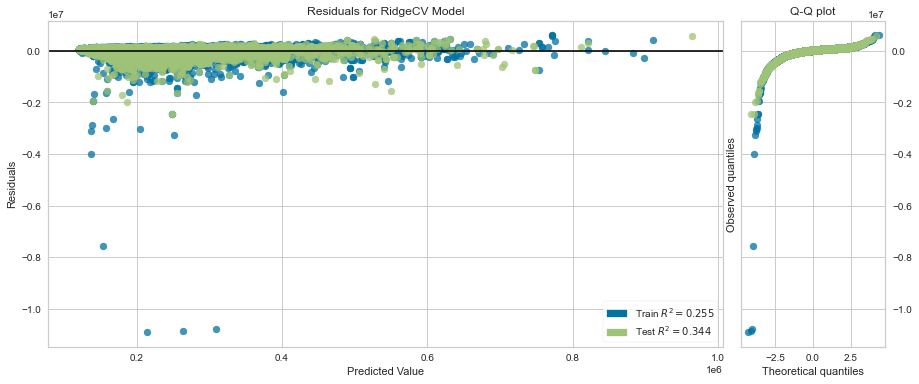

<AxesSubplot:title={'center':'Residuals for RidgeCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [113]:
# Visualizacion de los residuales
plt.figure(figsize = (15, 6))
residuals = ResidualsPlot(estimator = linear_reg_l2, hist = False, qqplot = True).fit(X_train_pol, y_train)
residuals.score(X_test_pol, y_test)
residuals.show()

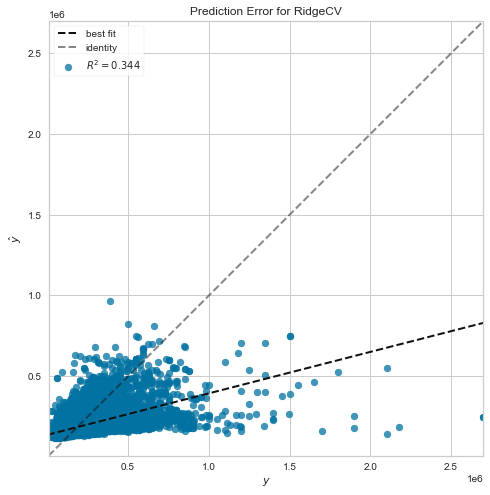

<AxesSubplot:title={'center':'Prediction Error for RidgeCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [114]:
# Visualizacion de la prediccion obtenida vs. la prediccion esperada
plt.figure(figsize = (8, 8))
prediction_error = PredictionError(estimator = linear_reg_l2).fit(X_train_pol, y_train)
prediction_error.score(X_test_pol, y_test)
prediction_error.show()

<!--  -->

#### 2.3) LASSO

A diferencia de la regularizacion L2, la L1 consigue excluir los predictores menos relevantes, es decir, que tiene el efecto de forzar a que los coeficientes de los predictores tiendan a cero.

In [115]:
# Creamos el modelo de regresion lineal con L1
linear_reg_l1 = LassoCV(alphas = np.logspace(-1, 10, 200), normalize = True, cv = 10)

_ = linear_reg_l1.fit(X_train_pol, y_train)

Text(0.5, 1.0, 'Coeficientes del modelo en función de la regularización')

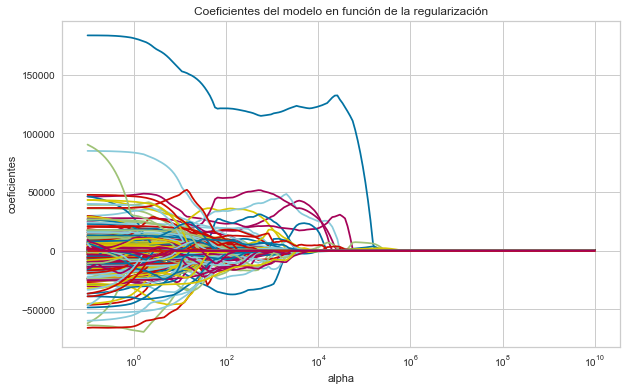

In [129]:
# Grafico de la atenuacion de los coeficientes de los predictores con el aumento de alpha
alphas = linear_reg_l1.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha = alpha, fit_intercept = False, normalize = True)
    modelo_temp.fit(X_train_pol, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización')

In [116]:
print(f'Mejor valor de alpha encontrado: {linear_reg_l1.alpha_}')

Mejor valor de alpha encontrado: 1.1226677735108135


In [117]:
df_coeficientes = pd.DataFrame({'predictor': X_train_pol.columns, 'coef': linear_reg_l1.coef_.flatten()})

print(f'De los {len(X_train_pol.columns.to_list())} predictores creados, se redujo a {len(df_coeficientes[df_coeficientes.coef != 0])} predictores mediante esta estrategia.')

De los 364 predictores creados, se redujo a 96 predictores mediante esta estrategia.


Text(0.5, 1.0, 'Coeficientes del modelo')

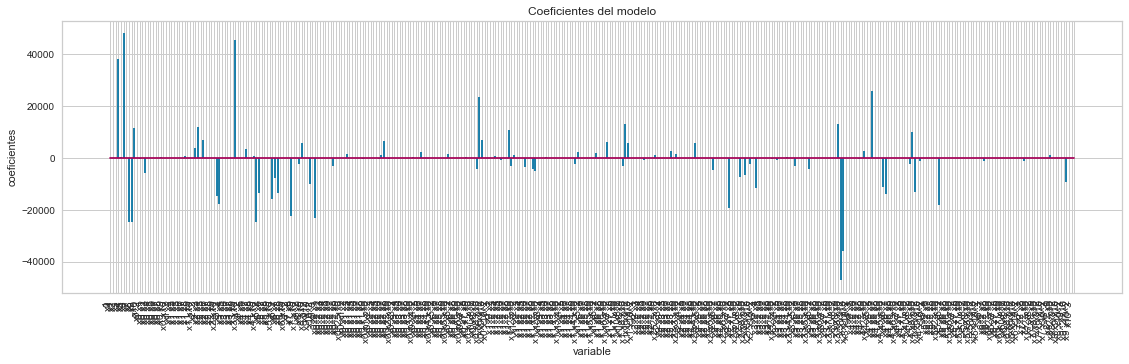

In [118]:
# Graficamos los coeficientes correspondientes a cada variable generada para el modelo
fig, ax = plt.subplots(figsize = (19, 5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt = ' ')
plt.xticks(rotation = 90, ha = 'right', size = 10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo')

In [119]:
# Imprimimos los resultados del modelo para X_train y X_test
print(f'El r2 en entrenamiento es: {linear_reg_l1.score(X_train_pol, y_train)}')
print(f'El r2 en prueba es: {linear_reg_l1.score(X_test_pol, y_test)}')
print(f'El RMSE en entrenamiento es: {mean_squared_error(y_train, linear_reg_l1.predict(X_train_pol), squared = False)}')
print(f'El RMSE en prueba es: {mean_squared_error(y_test, linear_reg_l1.predict(X_test_pol), squared = False)}')

El r2 en entrenamiento es: 0.3994899081850104
El r2 en prueba es: 0.5269235495092504
El RMSE en entrenamiento es: 109038.20908212467
El RMSE en prueba es: 84139.14126688246


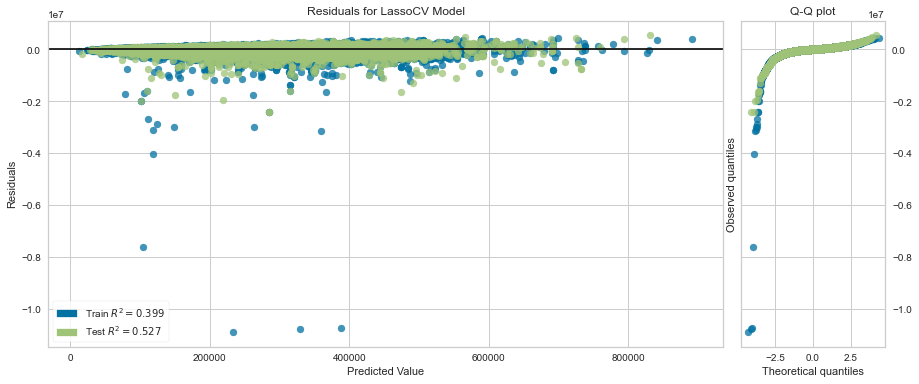

<AxesSubplot:title={'center':'Residuals for LassoCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [120]:
# Visualizacion de los residuales
plt.figure(figsize = (15, 6))
residuals = ResidualsPlot(estimator = linear_reg_l1, hist = False, qqplot = True).fit(X_train_pol, y_train)
residuals.score(X_test_pol, y_test)
residuals.show()

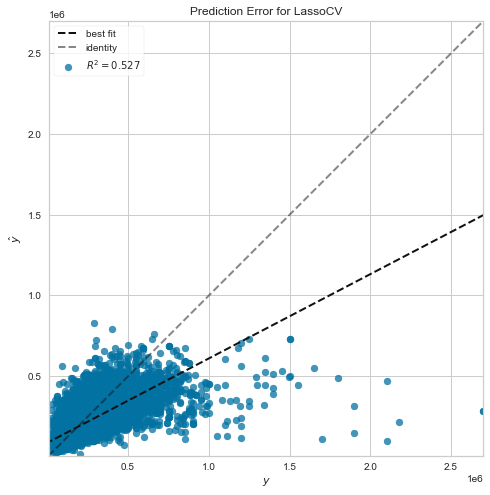

<AxesSubplot:title={'center':'Prediction Error for LassoCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [121]:
# Visualizacion de la prediccion obtenida vs. la prediccion esperada
plt.figure(figsize = (8, 8))
prediction_error = PredictionError(estimator = linear_reg_l1).fit(X_train_pol, y_train)
prediction_error.score(X_test_pol, y_test)
prediction_error.show()

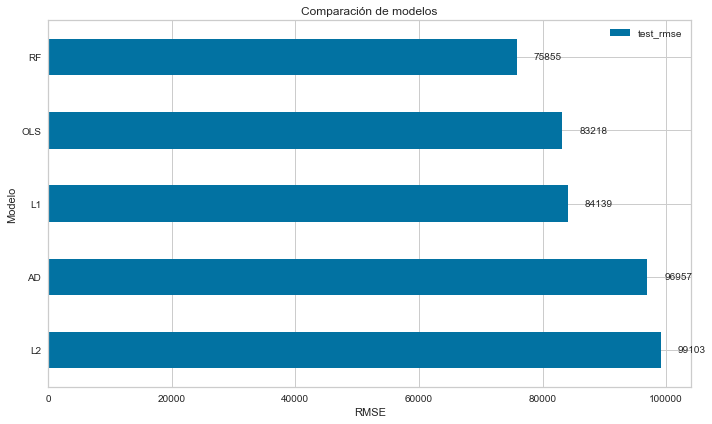

In [122]:
# RMSE de cada modelo generado
rmse_ad = mean_squared_error(y_test, y_test_pred_tree, squared = False) # Arbol de decision SPRINT 01
rmse_rf = mean_squared_error(y_test, rf.predict(X_test_enc), squared = False) # Random Forest
rmse_ols = mean_squared_error(y_test, linear_reg.predict(X_test_pol), squared = False) # Regresion lineal por Minimos cuadrados
rmse_l2 = mean_squared_error(y_test, linear_reg_l2.predict(X_test_pol), squared = False) # Regresion lineal con regularizacion Ridge
rmse_l1 = mean_squared_error(y_test, linear_reg_l1.predict(X_test_pol), squared = False) # Regresion lineal con regularizacion Lasso

# DF que contiene los resultados de RMSE de cada modelo
df_comparacion = pd.DataFrame({'modelo': ['AD', 'RF', 'OLS', 'L1', 'L2'],
                              'test_rmse': [rmse_ad, rmse_rf, rmse_ols, rmse_l1, rmse_l2]})

# Graficamos los RMSE
fig, ax = plt.subplots(figsize=(10, 6))
plot = df_comparacion.set_index('modelo').sort_values(by = 'test_rmse', ascending = False).plot(kind = 'barh', ax = ax)
# Colocar etiquetas de datos
for p in plot.patches:
    width = p.get_width()
    plot.text(p.get_width() + 5000, p.get_y() + p.get_height() / 2, '{:1.0f}'.format(width), ha = 'center', va = 'center')
    
ax.set_xlabel('RMSE')
ax.set_ylabel('Modelo')
ax.set_title('Comparación de modelos')
plt.tight_layout()

Analizando el grafico anterior, podemos decir que el mejor modelo obtenido es de `Random Forest` con un RMSE de 75855, es decir, que el modelo final se aleja en promedio 75855 unidades sobre el valor real.

<!--  -->

# 3) INTERPRETACION DE MODELOS

En las visualizaciones de los residuales, podemos ver que el grafico de Q-Q Plot, en el que se compara los cuartiles de los residuales con los cuartiles de una distribucion normal, no forman una linea recta, indicando que un modelo `no lineal` se ajusta mejor a nuestro problema, por lo que los modelos aplicados a nuestro problema son correctos, lo que no quiere decir que sean los mejores, ya que, como hemos visto, los valores de `r2` de todos los algoritmos no superan en ninguna ocacion el 70%. Esto quiere decir que gran parte de la variabilidad de nuestros datos no pueden ser explicados con los modelos expuestos.

Empezando por el `Random Forest`, analicemos las variables mas importantes segun este modelo:

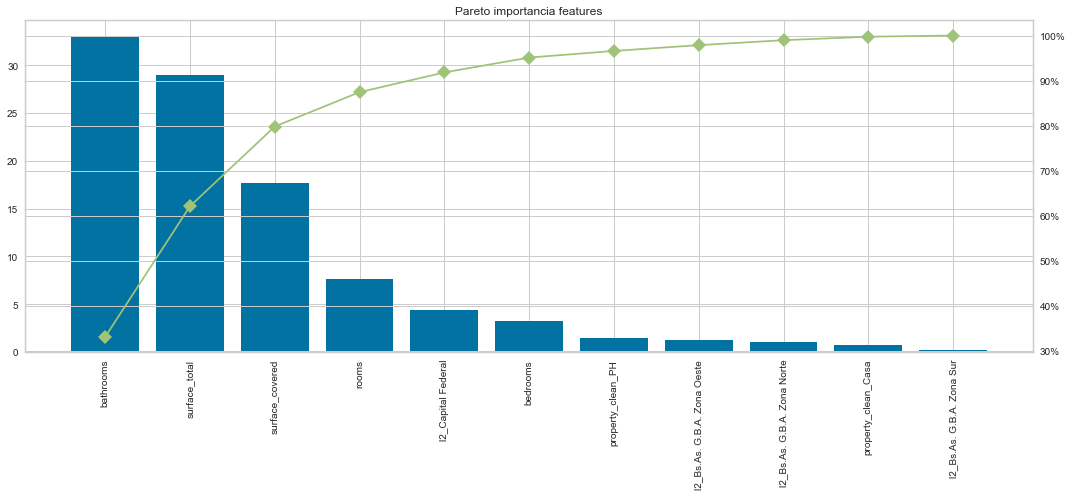

In [123]:
# DF con la importancia de las variables, ordenado de mayor a menor y agregado de porcentaje de importancia acumulado
feature_importances = pd.DataFrame(r_forest_cv.best_estimator_.feature_importances_ * 100, index = idx, columns = ['Importancia'])
feature_importances = feature_importances.sort_values(by = 'Importancia', ascending = False)
feature_importances['acumulado'] = feature_importances['Importancia'].cumsum() / feature_importances['Importancia'].sum() * 100

# Grafico Pareto
fig, ax = plt.subplots(figsize = (15, 7))
plt.xticks(rotation = 90)
ax.bar(feature_importances.index, feature_importances['Importancia'])
ax2 = ax.twinx() # Eje secundario 'y'
ax2.plot(feature_importances.index, feature_importances['acumulado'], color = 'g', marker = 'D', ms=10)
ax2.yaxis.set_major_formatter(PercentFormatter()) # Formato porcentaje para eje secundario 'y'
plt.title('Pareto importancia features')
plt.tight_layout()
plt.show()

Las variables que caen dentro del 80% de importancia en el grafico de Pareto son `bathrooms`, `surface_total` y `surface_covered`.

No se puede dejar de considerar la percepcion humana respecto al resultado obtenido frente a la logica de mercado, en donde si uno mismo busca algun tipo de propiedad como las consideradas en el modelo, el factor 'habitaciones' o `bedrooms` es un diferenciador clave del precio de la propiedad (estando en la 6° posicion en el modelo y con un peso menor al 5%). Comentario quizas con un poco de sesgo, pero no fuera de la logica.

Agregado a esto, no se realizo un analisis sobre la variable de salida, o en este caso, la variable objetivo `price`, por lo que asumimos que los precios estaban correctamente colocados, cuando observamos en un boxplot que varias de las observaciones caen en los "rangos" de outliers. Por lo que una posible mejora es (quizas) un analisis mas profundo sobre el comportamiento de la variable de salida.

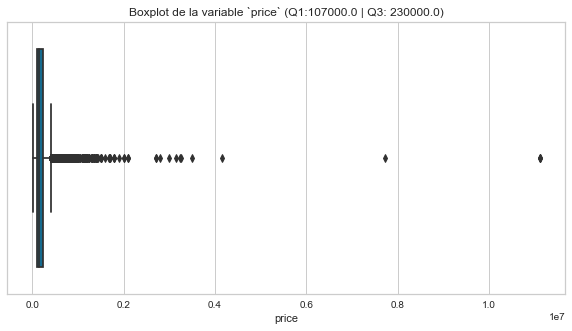

In [124]:
fig = plt.subplots(figsize = (10, 5))
sns.boxplot(y_train, orient = 'h')
q1 = y_train.quantile(0.25)
q3 = y_train.quantile(0.75)
plt.title(f'Boxplot de la variable `price` (Q1:{q1} | Q3: {q3})')
plt.show()

Analizaremos 4 arboles de forma aleatoria para ver como se comporta la importancia de las variables en el modelo y ver si mantienen la misma tendencia que la mencionada anteriormente:

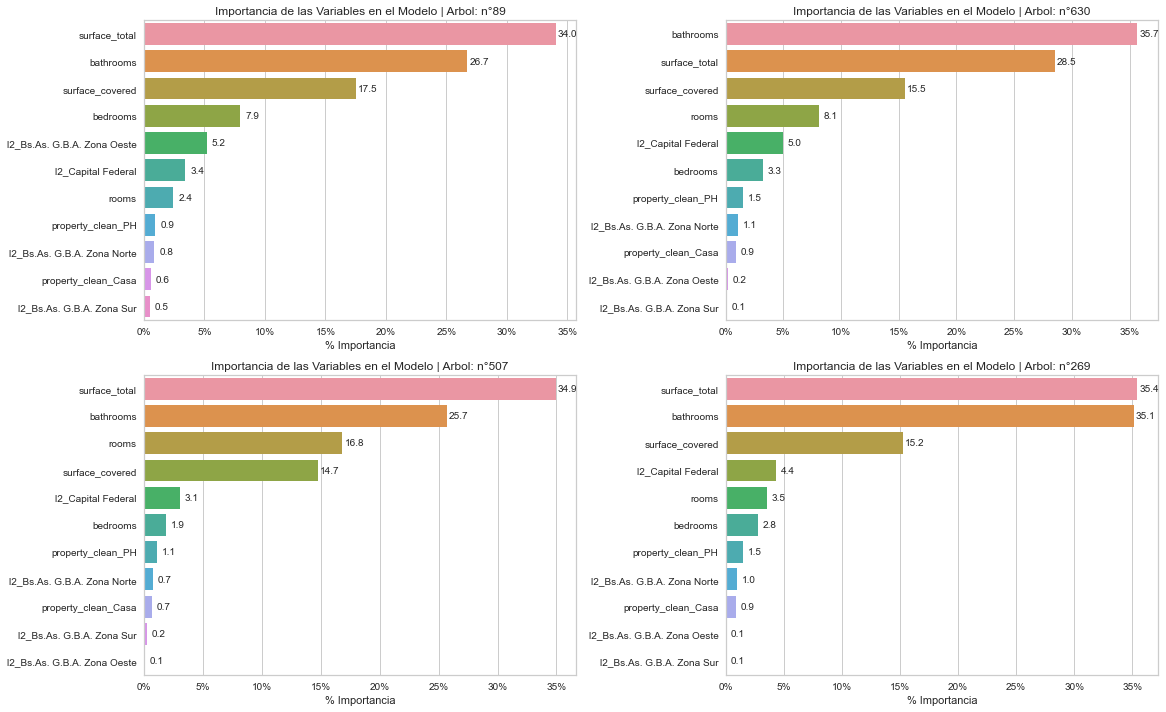

In [125]:
arboles = [89, 630, 507, 269] # Arboles seleccionados aleatoriamente

a = 2 # Numero de filas del subplot
b = 2 # Numero de columnas del subplot
c = 1 # Iniciador del contador

fig = plt.figure(figsize = (16.3, 10))

for arbol in arboles:
    plt.subplot(a, b, c)
    feature_importances = pd.DataFrame(r_forest_cv.best_estimator_[arbol].feature_importances_ * 100, index = idx, columns = ['Importancia'])
    # Grafico de importancia de las variables en el modelo
    plot = sns.barplot(data = feature_importances,
        x = 'Importancia',
        y = numerical_col_3, 
        order = feature_importances.sort_values(by = 'Importancia', ascending = False).index)
    # Colocar etiquetas de datos
    for p in plot.patches:
        width = p.get_width()
        plot.text(p.get_width() + 1, p.get_y() + p.get_height() / 2,
            '{:1.1f}'.format(width),
            ha = 'center', va = 'center')
    plot.xaxis.set_major_formatter(PercentFormatter(decimals = 0))
    plt.xlabel('% Importancia')
    plt.title(f'Importancia de las Variables en el Modelo | Arbol: n°{arbol}')
    c = c + 1 # Contador
    
plt.tight_layout()
plt.show()

Alterando un poco el orden pero manteniendo las mismas 3 variables dentro del 80% de importancia acumulada, lo obtenemos en los arboles `89`, `630` y `269`. Si bien en el arbol `507` la importancia de las variables cambia, estando `rooms` en el top 3 (cuando generalmente se encuentra entre las posiciones 5 y 7), tiene casi el mismo peso que la variable `surface_covered`.

<!--  -->

Enfocandonos en los modelos de `Regresion lineal con atributos polinomicos`, con y sin estrategias de regularizacion, no es posible hablar de los features en si como vimos en el `Random Forest` debido a la transformacion polinomica de los mismos. Pero de los 3 realizados, el modelo con estrategia de regularizacion `Ridge` fue el que obtuvo el peor desempeño.

Si bien el modelo de Regresion Lineal con estrategia de regularizacion `L1` o `Lasso` obtuvo casi el mismo desempeño que el calculado por `OLS`, la cantidad de variables consideradas para llegar practicamente al mismo resultado es significativamente menor, con poco mas del 56% de reduccion (364 variables a 96).

Analizando los errores:

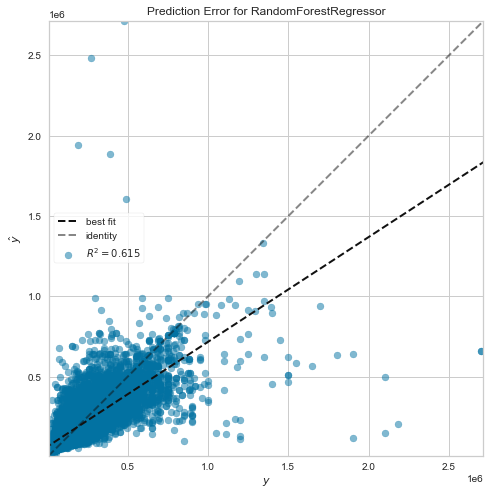

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [130]:
# Visualizacion de la prediccion obtenida vs. la prediccion esperada
plt.figure(figsize = (8, 8))
predictions_error = PredictionError(estimator = rf, alpha = 0.5).fit(X_train_enc, y_train)
predictions_error.score(X_test_enc, y_test)
predictions_error.show()

In [127]:
# r2 para cada combinacion posible entre 'propertyclean' y 'l2'
l2 = [col for col in X_train_enc.columns if col.startswith('l2')]
property_clean = [col for col in X_train_enc.columns if col.startswith('property_clean')]

# for loop para Casa y PH
for region in l2:
    for prop in property_clean:
        print(f'Para la region {region} y tipo de propiedad {prop}:\n')
        # Para conjunto de datos X_train
        x_train_rf = X_train_enc.loc[(X_train_enc[region] == 1) & (X_train_enc[prop] == 1)]
        idx = x_train_rf.index
        y_train_rf = y_train
        y_train_rf = y_train_rf[idx]
    
        # Para conjunto de datos X_test
        x_test_rf = X_test_enc.loc[(X_test_enc[region] == 1) & (X_test_enc[prop] == 1)]
        idx = x_test_rf.index
        y_test_rf = y_test
        y_test_rf = y_test_rf[idx]
    
        r2_train = round(rf.score(x_train_rf, y_train_rf), 3)
        r2_test = round(rf.score(x_test_rf, y_test_rf), 3)
    
        print(f'r2_train: {r2_train} \n r2_test: {r2_test} \n')
        print('--------------------------------------------------------------------------\n')

# for loop para Departamento
for region in l2:
    print(f'Para la region {region} y tipo de propiedad property_clean_Departamento:\n')
    # Para conjunto de datos X_train
    x_train_rf = X_train_enc.loc[(X_train_enc[region] == 1) & (X_train_enc['property_clean_Casa'] == 0) & (X_train_enc['property_clean_PH'] == 0)]
    idx = x_train_rf.index
    y_train_rf = y_train
    y_train_rf = y_train_rf[idx]
    
    # Para conjunto de datos X_test
    x_test_rf = X_test_enc.loc[(X_test_enc[region] == 1) & (X_test_enc['property_clean_Casa'] == 0) & (X_test_enc['property_clean_PH'] == 0)]
    idx = x_test_rf.index
    y_test_rf = y_test
    y_test_rf = y_test_rf[idx]
    
    r2_train = round(rf.score(x_train_rf, y_train_rf), 3)
    r2_test = round(rf.score(x_test_rf, y_test_rf), 3)
    
    print(f'r2_train: {r2_train} \n r2_test: {r2_test} \n')
    print('--------------------------------------------------------------------------\n')

Para la region l2_Bs.As. G.B.A. Zona Norte y tipo de propiedad property_clean_Casa:

r2_train: 0.75 
 r2_test: 0.328 

--------------------------------------------------------------------------

Para la region l2_Bs.As. G.B.A. Zona Norte y tipo de propiedad property_clean_PH:

r2_train: 0.769 
 r2_test: 0.392 

--------------------------------------------------------------------------

Para la region l2_Bs.As. G.B.A. Zona Oeste y tipo de propiedad property_clean_Casa:

r2_train: 0.836 
 r2_test: 0.085 

--------------------------------------------------------------------------

Para la region l2_Bs.As. G.B.A. Zona Oeste y tipo de propiedad property_clean_PH:

r2_train: 0.755 
 r2_test: 0.429 

--------------------------------------------------------------------------

Para la region l2_Bs.As. G.B.A. Zona Sur y tipo de propiedad property_clean_Casa:

r2_train: 0.652 
 r2_test: 0.4 

--------------------------------------------------------------------------

Para la region l2_Bs.As. G.B.

Del modelo de `Random Forest` obtuvimos los siguientes resultados:

- RMSE train: 71261.73
- RMSE test: 75855.49

De acuerdo a esto, podemos mencionar que al haber poca diferencia entre el conjunto de datos de train y test, el modelo no presenta problemas de overfitting, suponiendo una adecuada distribucion de los datos entre los conjuntos de datos de entrenamiento y prueba. Estamos ante un caso de bajo sesgo, ya que se eligio un modelo no lineal y se implemento remuestreo en la construccion del mismo para conseguir una eleccion "aleatoria" de los datos de entrenamiento para cada arbol de decision creado. Sin embargo, el modelo presenta un problema de alta varianza, ya que, como vimos, el error RMSE general es alto en funcion del rango de precios en donde se concentra el 50% de los datos (caja del boxplot).

Sumado a esto, se puede observar en el grafico de distribucion de los errores que estos van aumentando a medida que aumentan los precios de las propiedades, acertando mejor en aquellas clases o combinacion de clases (`l2` y `property_clean`) que tienen mayor cantidad de observaciones, como es el caso de Departamentos que se encuentra en Capital Federal.

Como mejoras para el modelo, poder reducir el error y/o poder lograr un mejor equilibrio entre sesgo y varianza puede conseguirse mediante:

- Aumento de cantidad de observaciones (se podria conseguir disminuir varianza, pero influiria sobre el sesgo).
- Implementacion o prueba con otros modelos que tengan mejores resultados y disminuyan el sesgo (modelos menos complejos, por ejemplo).
- Creacion de nuevas variables predictoras mediante Clusterizacion o PCA/SVD. 

<!--  -->

# 4) CIERRE

De acuerdo a todo lo analizado anteriormente, se logro un EDA con una profundidad de analisis mucho mayor comparado al SPRINT 01, entendiendo aun mas la complejidad del problema y el comportamiento e influencia de las variables presentes en el DS y las finalmente seleccionadas en el modelo. Y como uno de los puntos a mejorar, es el analisis de los outliers, donde en este proyecto se eliminaron, pero podria incluirse una mejora donde se traten y analicen los outliers para tener mayor cantidad de observaciones.

Personalmente esperaba un mejor resultado en el modelo creado durante el SPRINT 02, en el que, si bien logró reducir el error medido RMSE, no logra explicar la variabilidad de los datos respecto a la media tal como lo hace el modelo del SPRINT 01, y esto, como se menciono anteriormente, debido a la mayor cantidad de observaciones involucradas al igual que la cantidad de variables tenidas en cuenta. Sin embargo, recordando las premisas establecidas en el SPRINT 01, este logra un buen modelo pero ante un acotado DS, recayendo al overfitting.

<!--  -->

# <u>REQUERIMIENTOS ADICIONALES<u>

# 5) ADICIONAL

### 5.1) IMPLEMENTACION DE "ONE HOT ENCODER"

Ademas de la posibilidad de codificar las variables categoricas para su utilizacion en Machine Learning mediante dummies, podemos, de manera similar, hacer codificacion mediante:

1) LabelEncoder
2) OneHotEncoder

La primera tiene la ventaja que no crea mayor cantidad de variables, sino que transforma las categorias con un valor numerico unico por cada categoria. Es una metodologia muy util para cuando se quieren analizar correlaciones de variables categoricas con las numericas durante el EDA, pero si el deseo es de agregarlas al modelo de Machine Learning, al utilizar valores desde 0 hasta 'n', este interpretara aumento y descenso de valores, cuando realmente no es mas que una categorizacion.

Como solucion a este problema (y es por esto que elegimos este algoritmo) esta la segunda opcion, donde, de manera similar a `get_dummies`, crea una variable por cada categoria de 0s y 1s para su identificacion por cada observacion. La desventaja es que el modelo obtiene tantas nuevas variables como categorias tiene el DS, por lo que si es un DS con muchas categorias, el modelo se torna mas complejo.

In [171]:
# Creamos el algoritmo de codificacion
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

In [172]:
# Lista de variables categoricas
categorical_col_2 = X_train.select_dtypes(exclude = 'number').columns.to_list()
categorical_col_2

['l2', 'property_clean']

In [187]:
# Entrenamos y transformamos para X_train
ohe_col_train = pd.DataFrame(ohe.fit_transform(X_train[categorical_col_2]))
# Transformamos para X_test
ohe_col_test = pd.DataFrame(ohe.transform(X_test[categorical_col_2]))
# Arrays de categorias a codificar
ohe.categories_

[array(['Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Oeste',
        'Bs.As. G.B.A. Zona Sur', 'Capital Federal'], dtype=object),
 array(['Casa', 'Departamento', 'PH'], dtype=object)]

In [188]:
# Copiamos los conjuntos de datos para no trabajar sobre los originales
X_train_ohe = X_train.copy()
X_test_ohe = X_test.copy()

In [189]:
# Definimos los indices de los DF codificados para luego concatenar con las variables numericas
ohe_col_train.index = X_train_ohe.index
ohe_col_test.index = X_test_ohe.index

In [185]:
# Dejamos unicamente los DF con variables numericas
num_X_train = X_train.drop(categorical_col_2, axis = 1)
num_X_test = X_test.drop(categorical_col_2, axis = 1)

In [202]:
# Concatenamos las variables categoricas ya codificadas con las variables numericas
ohe_train = pd.concat([num_X_train, ohe_col_train], axis = 1)
ohe_test = pd.concat([num_X_test, ohe_col_test], axis = 1)

In [210]:
# Renombramos las variables codificadas con sus nombres origianles para X_train
ohe_train.rename(columns = 
                {0: 'Bs.As. G.B.A. Zona Norte',
                1: 'Bs.As. G.B.A. Zona Oeste',
                2: 'Bs.As. G.B.A. Zona Sur',
                3: 'Capital Federal',
                4: 'Casa',
                5: 'Departamento',
                6: 'PH'}, inplace = True)
# Renombramos las variables codificadas con sus nombres origianles para X_test
ohe_test.rename(columns = 
                {0: 'Bs.As. G.B.A. Zona Norte',
                1: 'Bs.As. G.B.A. Zona Oeste',
                2: 'Bs.As. G.B.A. Zona Sur',
                3: 'Capital Federal',
                4: 'Casa',
                5: 'Departamento',
                6: 'PH'}, inplace = True)

print(f'train: {ohe_train.shape}, test: {ohe_test.shape}')

train: (87544, 12), test: (37612, 12)


### ESCALADO DE DATOS

In [211]:
# Construimos el scaler en funcion de X_train
scaler = RobustScaler().fit(ohe_train[numerical_col])

In [212]:
# Transformacion de los datos para X_train
ohe_train.loc[:, numerical_col] = scaler.transform(ohe_train[numerical_col])
# Transformacion de los datos para X_test
ohe_test.loc[:, numerical_col] = scaler.transform(ohe_test[numerical_col])

In [213]:
# Lista con todas las variables numericas del DS
numerical_col_4 = ohe_train.select_dtypes(include = 'number').columns.to_list()
numerical_col_4

['rooms',
 'bedrooms',
 'bathrooms',
 'surface_total',
 'surface_covered',
 'Bs.As. G.B.A. Zona Norte',
 'Bs.As. G.B.A. Zona Oeste',
 'Bs.As. G.B.A. Zona Sur',
 'Capital Federal',
 'Casa',
 'Departamento',
 'PH']

In [214]:
# Calculo del VIF
VIF = calculate_vif(data = ohe_train[numerical_col_4])
VIF

,feature,VIF
0,rooms,5.610201
1,bedrooms,4.555912
2,bathrooms,1.681943
3,surface_total,3.397640
4,surface_covered,4.437178
5,Bs.As. G.B.A. Zona Norte,inf
6,Bs.As. G.B.A. Zona Oeste,inf
7,Bs.As. G.B.A. Zona Sur,inf
8,Capital Federal,inf
9,Casa,inf


In [216]:
numerical_col_5 = ohe_train.drop(['Departamento'], axis = 1).select_dtypes(include = 'number').columns.to_list()

In [217]:
# Calculo del VIF
VIF = calculate_vif(data = ohe_train[numerical_col_5])
VIF

,feature,VIF
0,rooms,5.610201
1,bedrooms,4.555912
2,bathrooms,1.681943
3,surface_total,3.397641
4,surface_covered,4.437216
5,Bs.As. G.B.A. Zona Norte,1.391696
6,Bs.As. G.B.A. Zona Oeste,1.277456
7,Bs.As. G.B.A. Zona Sur,1.497363
8,Capital Federal,1.769029
9,Casa,3.258378


In [218]:
ohe_train.drop(['Departamento'], axis = 1, inplace = True)
ohe_test.drop(['Departamento'], axis = 1, inplace = True)

print(f'X_train shape: {ohe_train.shape} \n X_test shape: {ohe_test.shape}')

X_train shape: (87544, 11) 
 X_test shape: (37612, 11)


In [219]:
# Generamos el Random Forest
r_forest = RandomForestRegressor()

In [220]:
# Definicion de los parametros para el GridSearch
params = {
    'n_estimators': [300, 500, 700, 900],
    'criterion': ['mse'],
    'max_depth': [2, 5, 8, 12, 15],
    'oob_score': [True],
    'random_state': [42],
    'n_jobs': [-1],
    'ccp_alpha': [0.001, 0.01]
}

In [221]:
# Definimos el GridSearch para un algoritmo del tipo RandomForest
r_forest_cv = GridSearchCV(estimator = r_forest, param_grid = params, cv = 5, n_jobs = -1)

In [222]:
# Entrenamos el modelo con los parametros definidos
r_forest_cv.fit(X_train_enc, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.001, 0.01], 'criterion': ['mse'],
                         'max_depth': [2, 5, 8, 12, 15],
                         'n_estimators': [300, 500, 700, 900], 'n_jobs': [-1],
                         'oob_score': [True], 'random_state': [42]})

In [223]:
# Mejores parametros de la grilla definida
r_forest_cv.best_params_

{'ccp_alpha': 0.001,
 'criterion': 'mse',
 'max_depth': 15,
 'n_estimators': 700,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 42}

In [224]:
# Predecimos la variable objetivo
y_train_pred_rf = r_forest_cv.predict(X_train_enc)
y_test_pred_rf = r_forest_cv.predict(X_test_enc)

In [225]:
# Calculo de los errores para X_train teniendo en cuenta los mejores estimadores
rf = r_forest_cv.best_estimator_

print(f"El MAE en entrenamiento es: {round(mean_absolute_error(y_train, rf.predict(X_train_enc)), 2)}")
print(f"El MAPE en entrenamiento es: {round(mean_absolute_percentage_error(y_train, rf.predict(X_train_enc)), 2) * 100}")
print(f"El RMSE en entrenamiento es: {round(mean_squared_error(y_train, rf.predict(X_train_enc), squared = False), 2)}")
print(f"El R2 en entrenamiento es: {round(rf.score(X_train_enc, y_train), 3)}")

El MAE en entrenamiento es: 34537.86
El MAPE en entrenamiento es: 21.0
El RMSE en entrenamiento es: 71261.73
El R2 en entrenamiento es: 0.744


In [226]:
# Calculo de los errores para X_test teniendo en cuenta los mejores estimadores
print(f"El MAE en prueba es: {round(mean_absolute_error(y_test, rf.predict(X_test_enc)), 2)}")
print(f"El MAPE en prueba es: {round(mean_absolute_percentage_error(y_test, rf.predict(X_test_enc)), 4) * 100}")
print(f"El RMSE en prueba es: {round(mean_squared_error(y_test, rf.predict(X_test_enc), squared = False), 2)}")
print(f"El R2 en prueba es: {round(rf.score(X_test_enc, y_test), 3)}")

El MAE en prueba es: 40996.71
El MAPE en prueba es: 24.59
El RMSE en prueba es: 75855.49
El R2 en prueba es: 0.615


In [227]:
# Creamos un DF de variables e importancia por cada variable
idx = numerical_col_5
feature_importances = pd.DataFrame(r_forest_cv.best_estimator_.feature_importances_ * 100, index = idx, columns = ['Importancia'])

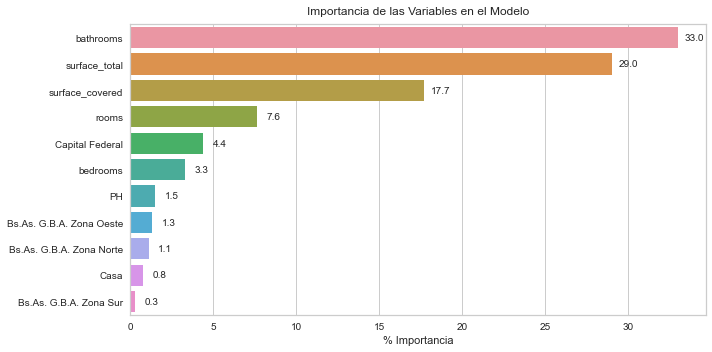

In [229]:
# Grafico de importancia de las variables en el modelo
plt.figure(figsize = (10, 5))
# Grafico
plot = sns.barplot(data = feature_importances,
            x = 'Importancia',
            y = numerical_col_5, 
            order = feature_importances.sort_values(by = 'Importancia', ascending = False).index)
# Colocar etiquetas de datos
for p in plot.patches:
    width = p.get_width()
    plot.text(p.get_width() + 1, p.get_y() + p.get_height() / 2,
             '{:1.1f}'.format(width),
             ha = 'center', va = 'center')
plt.xlabel('% Importancia')
plt.title('Importancia de las Variables en el Modelo', pad = 10)
plt.tight_layout()

<!--  -->

Obutivmos los mismos resultados que con la transformacion `get_dummies`. Si bien con `OneHotEncoder` tenemos la ventaja de que si hay diferencia de variables categoricas entre X_train y X_test este algoritmo lo arregla creando esa variable faltante con ceros, el modelo no presenta ese problema, por lo que la utilizacion de un algoritmo u otro es indiferente.